# Final MVP - Datada Team - Vietnam Datathon Contest

## Time Series Analysis

### **Sales data area**

Sales data are collected every month from 2022-2023, the files follow the format

`TT T<month>-<year>.xlsx`

Where

`<month>` represents the month number (from 01 to 12)

`<year>` represents year number (2022 or 2023).

For example, the file “TT T01-2022.xlss” represents the sales data for January 2022

Each file includes the following data fields:

- `month`: month in year
- `week`: week in year
- `site`: warehouse/store ID
- `branch_id`: the branch ID
- `channel_id`: code of distribution channel
- `distribution_channel_code`: Determine the distribution channel’s unique code.
- `sold_quantity`: the number of products or units that have been sole (số lượng tiêu thụ)
- `cost_price`: the direct costs associated with producing or purchasing the goods that a company sells during a specific accounting period (Trị giá tiêu thụ -  giá vốn)
- `net_price`: the final price of a product (trị giá tiêu thị - giá sau chiết khấu)
- `customer_id`: the customer ID
- `product_id`: the product ID

### Import neccessary libraries

In [1]:
import pandas as pd
import numpy as np
import glob
import os

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from keras.models import Sequential
from keras.layers import Dense, LSTM

import warnings
warnings.filterwarnings('ignore')

### Merge multiple files `TT T<month>-<year>.xlsx` into one

In [2]:
if os.path.isfile('../clean_data/sales.csv'):
    sales_data = pd.read_csv('../clean_data/sales.csv')
else:
    # Set the path to your dataset files
    sales_files = glob.glob("../data/Sales_mentor/TT T*.xlsx")

    # Initialize an empty DataFrame to store the sales data
    sales_data = pd.DataFrame()

    # Read each sales file and concatenate them into a single DataFrame
    for file in sales_files:
        df = pd.read_excel(file)
        sales_data = pd.concat([sales_data, df], ignore_index=True)

In [4]:
sales_data

,month,week,site,branch_id,channel_id,distribution_channel,distribution_channel_code,sold_quantity,cost_price,net_price,customer_id,product_id
0,2022001,202203,1800,1800,Online,Online,ZF2,3,3465960,4816665,02757bde1,aa01577e94a049c395087645063c5275NAU42
1,2022001,202202,1105,1100,CHTT,Bán lẻ,FP,1,231200,340000,3dd717588,c5e8835a14e74ee2ba476536bedbd7e0DEN44
2,2022001,202204,1147,1100,CHTT,Bán lẻ,FP,1,238000,350000,255bcbc83,d62c72df8f454e3b8cb3fe9fc0c508abDEN43
3,2022001,202202,1502,1500,CHTT,Bán lẻ,FP,1,244800,360000,948340f03,4615b124d7a743d6b536515c2fb486b5DEN37
4,2022001,202204,1115,1100,CHTT,Bán lẻ,FP,1,125800,185000,0ad09228f,4cabab90b40841b4b100cdc0969742aaDOO39
...,...,...,...,...,...,...,...,...,...,...,...,...
2495918,2022012,202252,1100,1100,TGPP,Phát sinh,ZF3,1,69434,79645,a3f1429b7,16fed9174bd84166893eab741c641316HOD38
2495919,2022012,202249,1513,1500,CHTT,Bán lẻ,FP,1,212308,250000,3ec77a1f4,26716e2d85294a31b32807473ce76d0fXNH36
2495920,2022012,202252,1101,1100,CHTT,Bán lẻ,FP,1,379885,559000,dd5a95cfa,34e8a3fbf13245749251726178b2756cHOG39
2495921,2022012,202250,1100,1100,TGPP,Hợp đồng,ZF1,3,650946,746673,ecaa638ff,0b45b1a1fd5a4b009d4a20fb355b2486XDG36


In [19]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2442470 entries, 0 to 2442469
Data columns (total 12 columns):
 #   Column                     Dtype 
---  ------                     ----- 
 0   month                      int64 
 1   week                       int64 
 2   site                       int64 
 3   branch_id                  int64 
 4   channel_id                 object
 5   distribution_channel       object
 6   distribution_channel_code  object
 7   sold_quantity              int64 
 8   cost_price                 int64 
 9   net_price                  int64 
 10  customer_id                object
 11  product_id                 object
dtypes: int64(7), object(5)
memory usage: 223.6+ MB


In [20]:
sales_data.describe()

,month,week,site,branch_id,sold_quantity,cost_price,net_price
count,2.442470e+06,2.442470e+06,2.442470e+06,2.442470e+06,2.442470e+06,2.442470e+06,2.442470e+06
mean,2.022310e+06,2.022529e+05,1.283691e+03,1.265501e+03,1.414988e+00,3.066163e+05,4.006175e+05
std,4.590361e+02,4.385558e+01,2.144573e+02,2.195704e+02,4.574894e+00,6.201720e+05,7.124241e+05
min,2.022001e+06,2.021530e+05,1.100000e+03,1.100000e+03,-2.500000e+02,-3.085228e+07,-3.251862e+07
25%,2.022005e+06,2.022180e+05,1.118000e+03,1.100000e+03,1.000000e+00,1.201740e+05,1.619500e+05
50%,2.022009e+06,2.022370e+05,1.200000e+03,1.200000e+03,1.000000e+00,2.074000e+05,2.900000e+05
75%,2.023001e+06,2.023030e+05,1.502000e+03,1.500000e+03,1.000000e+00,3.282500e+05,4.600000e+05
max,2.023007e+06,2.023520e+05,2.001000e+03,2.000000e+03,5.000000e+03,2.002900e+08,2.474178e+08


In [21]:
missing_values = sales_data.isnull().sum()
missing_values

month                        0
week                         0
site                         0
branch_id                    0
channel_id                   0
distribution_channel         0
distribution_channel_code    0
sold_quantity                0
cost_price                   0
net_price                    0
customer_id                  0
product_id                   0
dtype: int64

In [6]:
duplicate_rows = sales_data.duplicated()

# Print the number of duplicate rows
print(f'Number of duplicate rows: {duplicate_rows.sum()}')

Number of duplicate rows: 0


In [5]:
# Delete duplicate rows
sales_data = sales_data.drop_duplicates()

# Print the number of rows after deleting duplicates
print(f'Number of rows after deleting duplicates: {len(sales_data)}')

Number of rows after deleting duplicates: 2442470


### **Some EDA**

In [57]:
for col in sales_data.dtypes.index:
    # Check data type of column
    if sales_data[col].dtype == 'object':
        print("\nTOTAL UNIQUE VALUE IN THE COL {}".format(col),sales_data[col].nunique())


TOTAL UNIQUE VALUE IN THE COL channel_id 5

TOTAL UNIQUE VALUE IN THE COL distribution_channel 7



TOTAL UNIQUE VALUE IN THE COL distribution_channel_code 9

TOTAL UNIQUE VALUE IN THE COL customer_id 1191

TOTAL UNIQUE VALUE IN THE COL product_id 35471


In [7]:
sales_data['channel_id'] = sales_data['channel_id'].replace({'Online': 'ONLINE'})


In [8]:
sales_data['total_sales'] = sales_data['sold_quantity'] * sales_data['net_price']

# Calculate total sales for each branch/warehouse
total_sales_per_channel = sales_data.groupby(['channel_id', 'month', 'week'])['total_sales'].sum().reset_index()

# Calculate total sales for each product
total_sales_per_distribution_channel = sales_data.groupby(['distribution_channel', 'month', 'week'])['total_sales'].sum().reset_index()

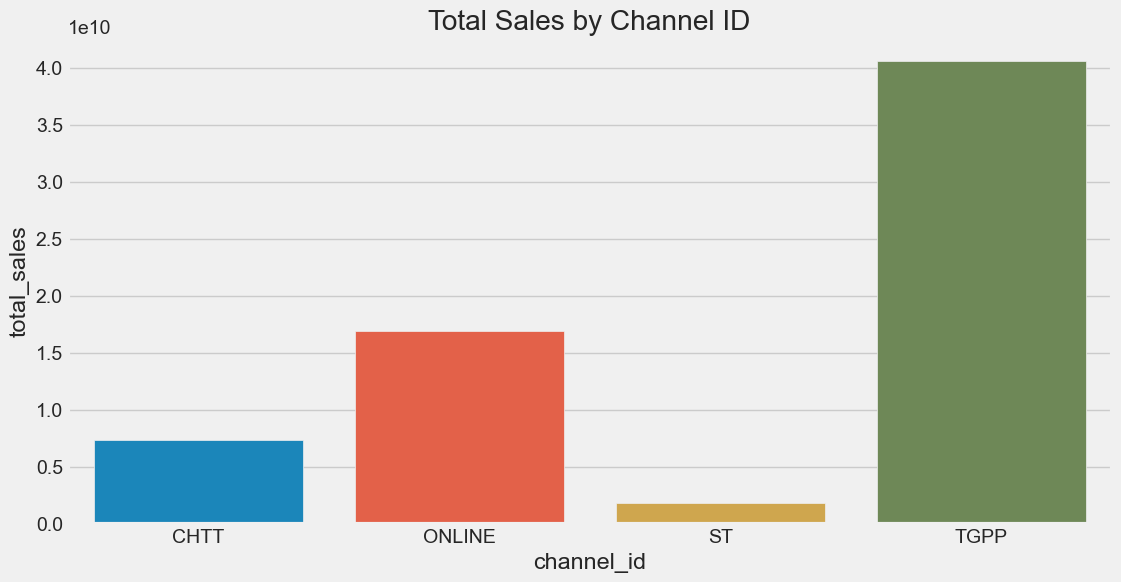

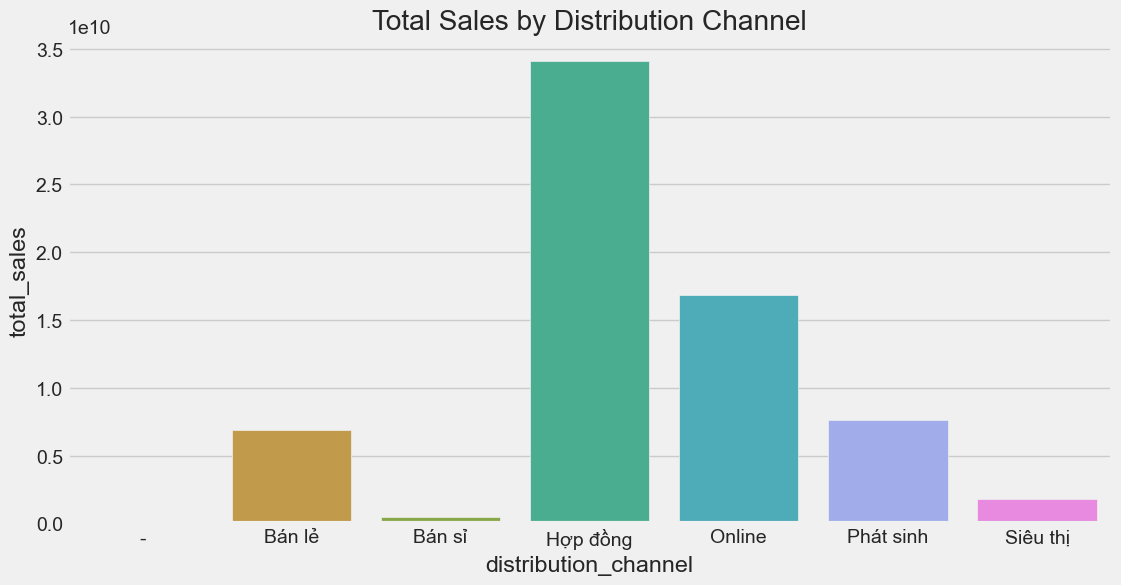

In [60]:
# Visualize the results
plt.figure(figsize=(12, 6))
sns.barplot(x='channel_id', y='total_sales', data=total_sales_per_channel, ci=None)
plt.title('Total Sales by Channel ID')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='distribution_channel', y='total_sales', data=total_sales_per_distribution_channel, ci=None)
plt.title('Total Sales by Distribution Channel')
plt.show()

### **Preprocessing**

In [9]:
# Assuming 'df' is your DataFrame
sales_data['year'] = sales_data['month'].astype(str).str[:4].astype(int)
sales_data['month'] = sales_data['month'].astype(str).str[-2:].astype(int)
sales_data['week'] = sales_data['week'].astype(str).str[-2:].astype(int)  # Extract the last two digits to get the week

# Now 'year', 'month', and 'week' are extracted as separate columns

# Display the modified DataFrame
sales_data[['year', 'month', 'week']]

,year,month,week
0,2022,1,3
1,2022,1,2
2,2022,1,4
3,2022,1,2
4,2022,1,4
...,...,...,...
2495918,2022,12,52
2495919,2022,12,49
2495920,2022,12,52
2495921,2022,12,50


Let's convert `year` and `week of year` to `date`

In [10]:
dates = sales_data.year*100+sales_data.week
sales_data['date'] = pd.to_datetime(dates.astype(str) + '0', format='%Y%W%w')
sales_data = sales_data.drop(['year', 'month', 'week'], axis=1)
sales_data['date']

0         2022-01-23
1         2022-01-16
2         2022-01-30
3         2022-01-16
4         2022-01-30
             ...    
2495918   2023-01-01
2495919   2022-12-11
2495920   2023-01-01
2495921   2022-12-18
2495922   2022-12-25
Name: date, Length: 2442470, dtype: datetime64[ns]

In [16]:
# Calculate total cost for each transaction
sales_data['total_cost'] = sales_data['sold_quantity'] * sales_data['cost_price']

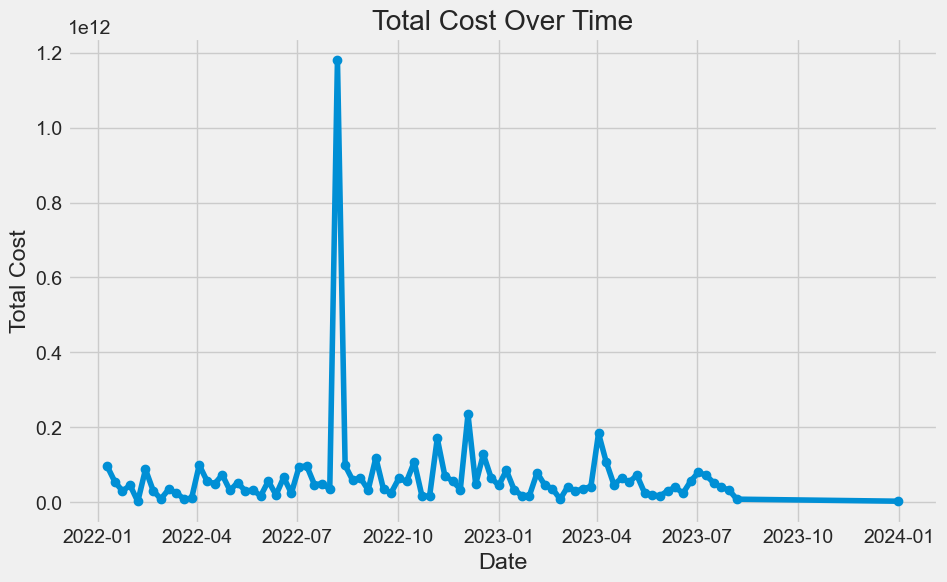

In [64]:
# Aggregate total cost over time

total_cost_over_time = sales_data.groupby(['date'])['total_cost'].sum().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(total_cost_over_time['date'], total_cost_over_time['total_cost'], marker='o')
plt.title('Total Cost Over Time')
plt.xlabel('Date')
plt.ylabel('Total Cost')
plt.grid(True)
plt.show()

In [17]:
# Calculate profit for each transaction
sales_data['profit'] = (sales_data['sold_quantity'] >= 0).mul(sales_data['total_sales']) - sales_data['total_cost']

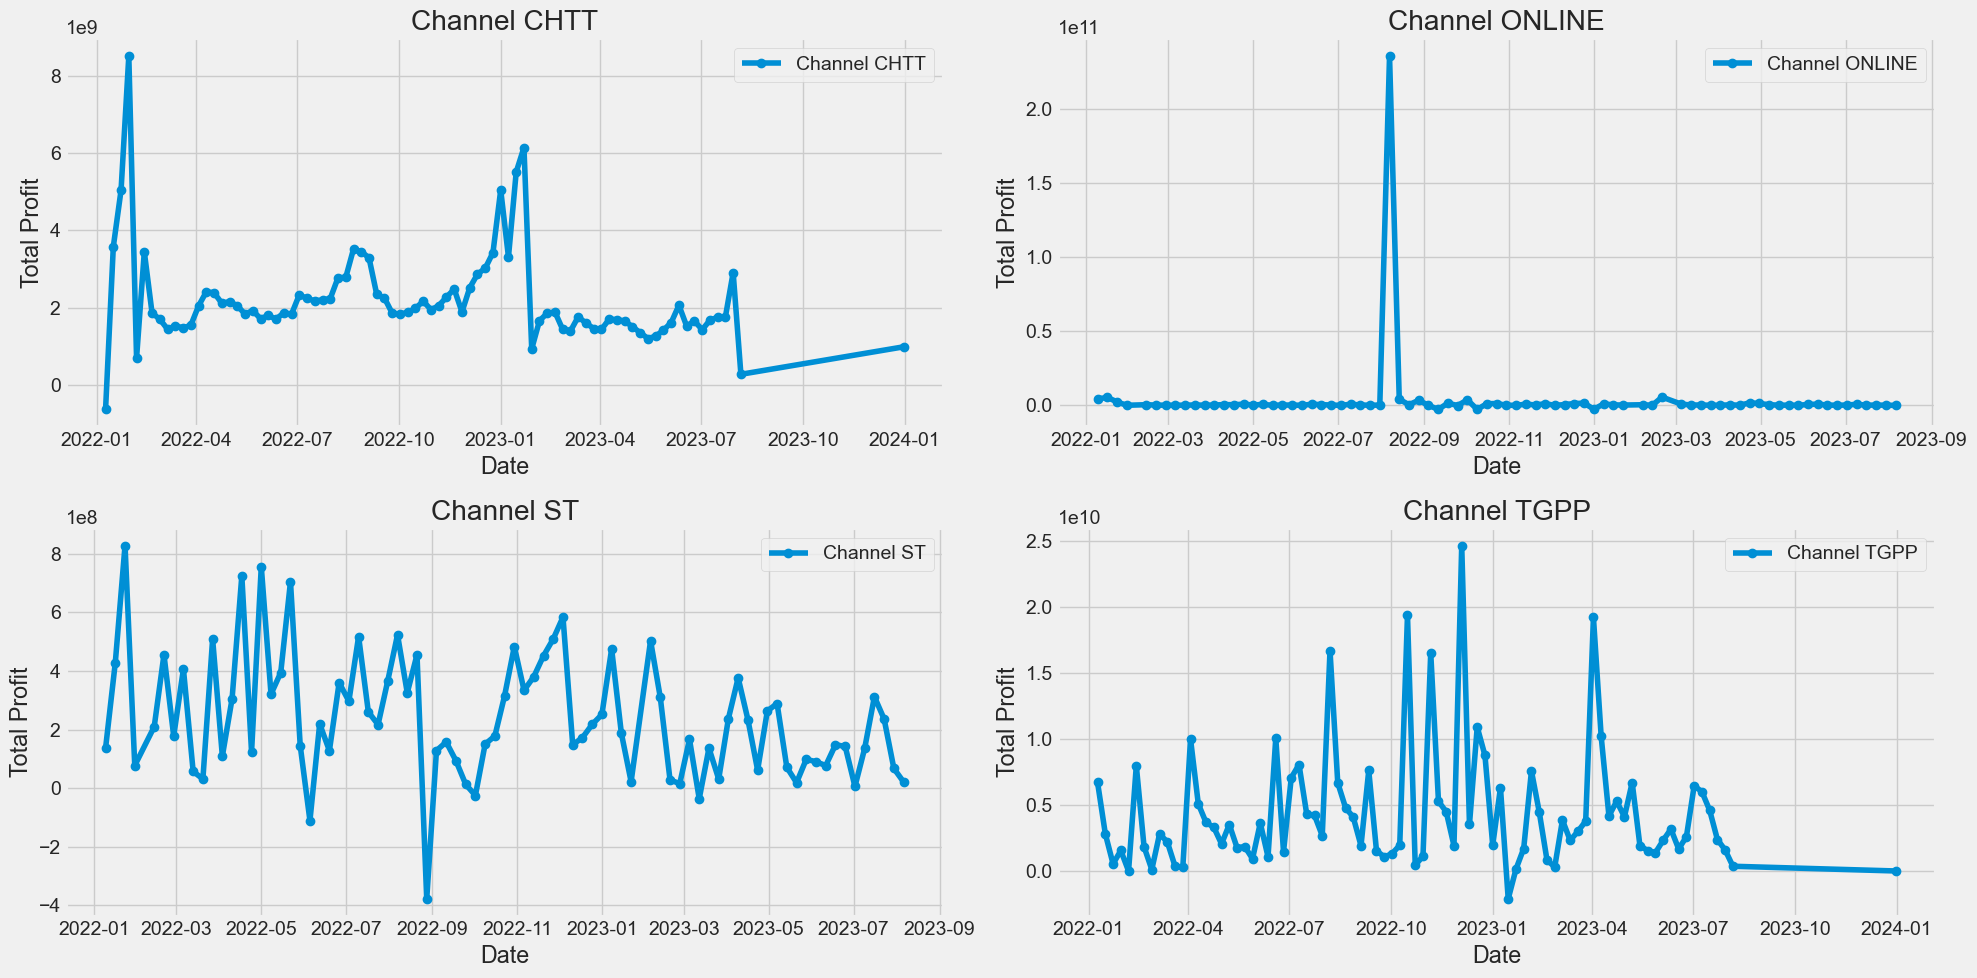

In [28]:
total_profit_over_time = sales_data.groupby(['date', 'channel_id'])['profit'].sum().reset_index()

fig, axs = plt.subplots(2, 2, figsize=(20, 10))
axs = axs.ravel()

# Plot a line for each channel_id
for i, channel in enumerate(total_profit_over_time['channel_id'].unique()):
    data = total_profit_over_time[total_profit_over_time['channel_id'] == channel]
    axs[i].plot(data['date'], data['profit'], marker='o', label=f'Channel {channel}')
    axs[i].set_title(f'Channel {channel}')
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Total Profit')
    axs[i].grid(True)
    axs[i].legend()

plt.tight_layout()
plt.show()

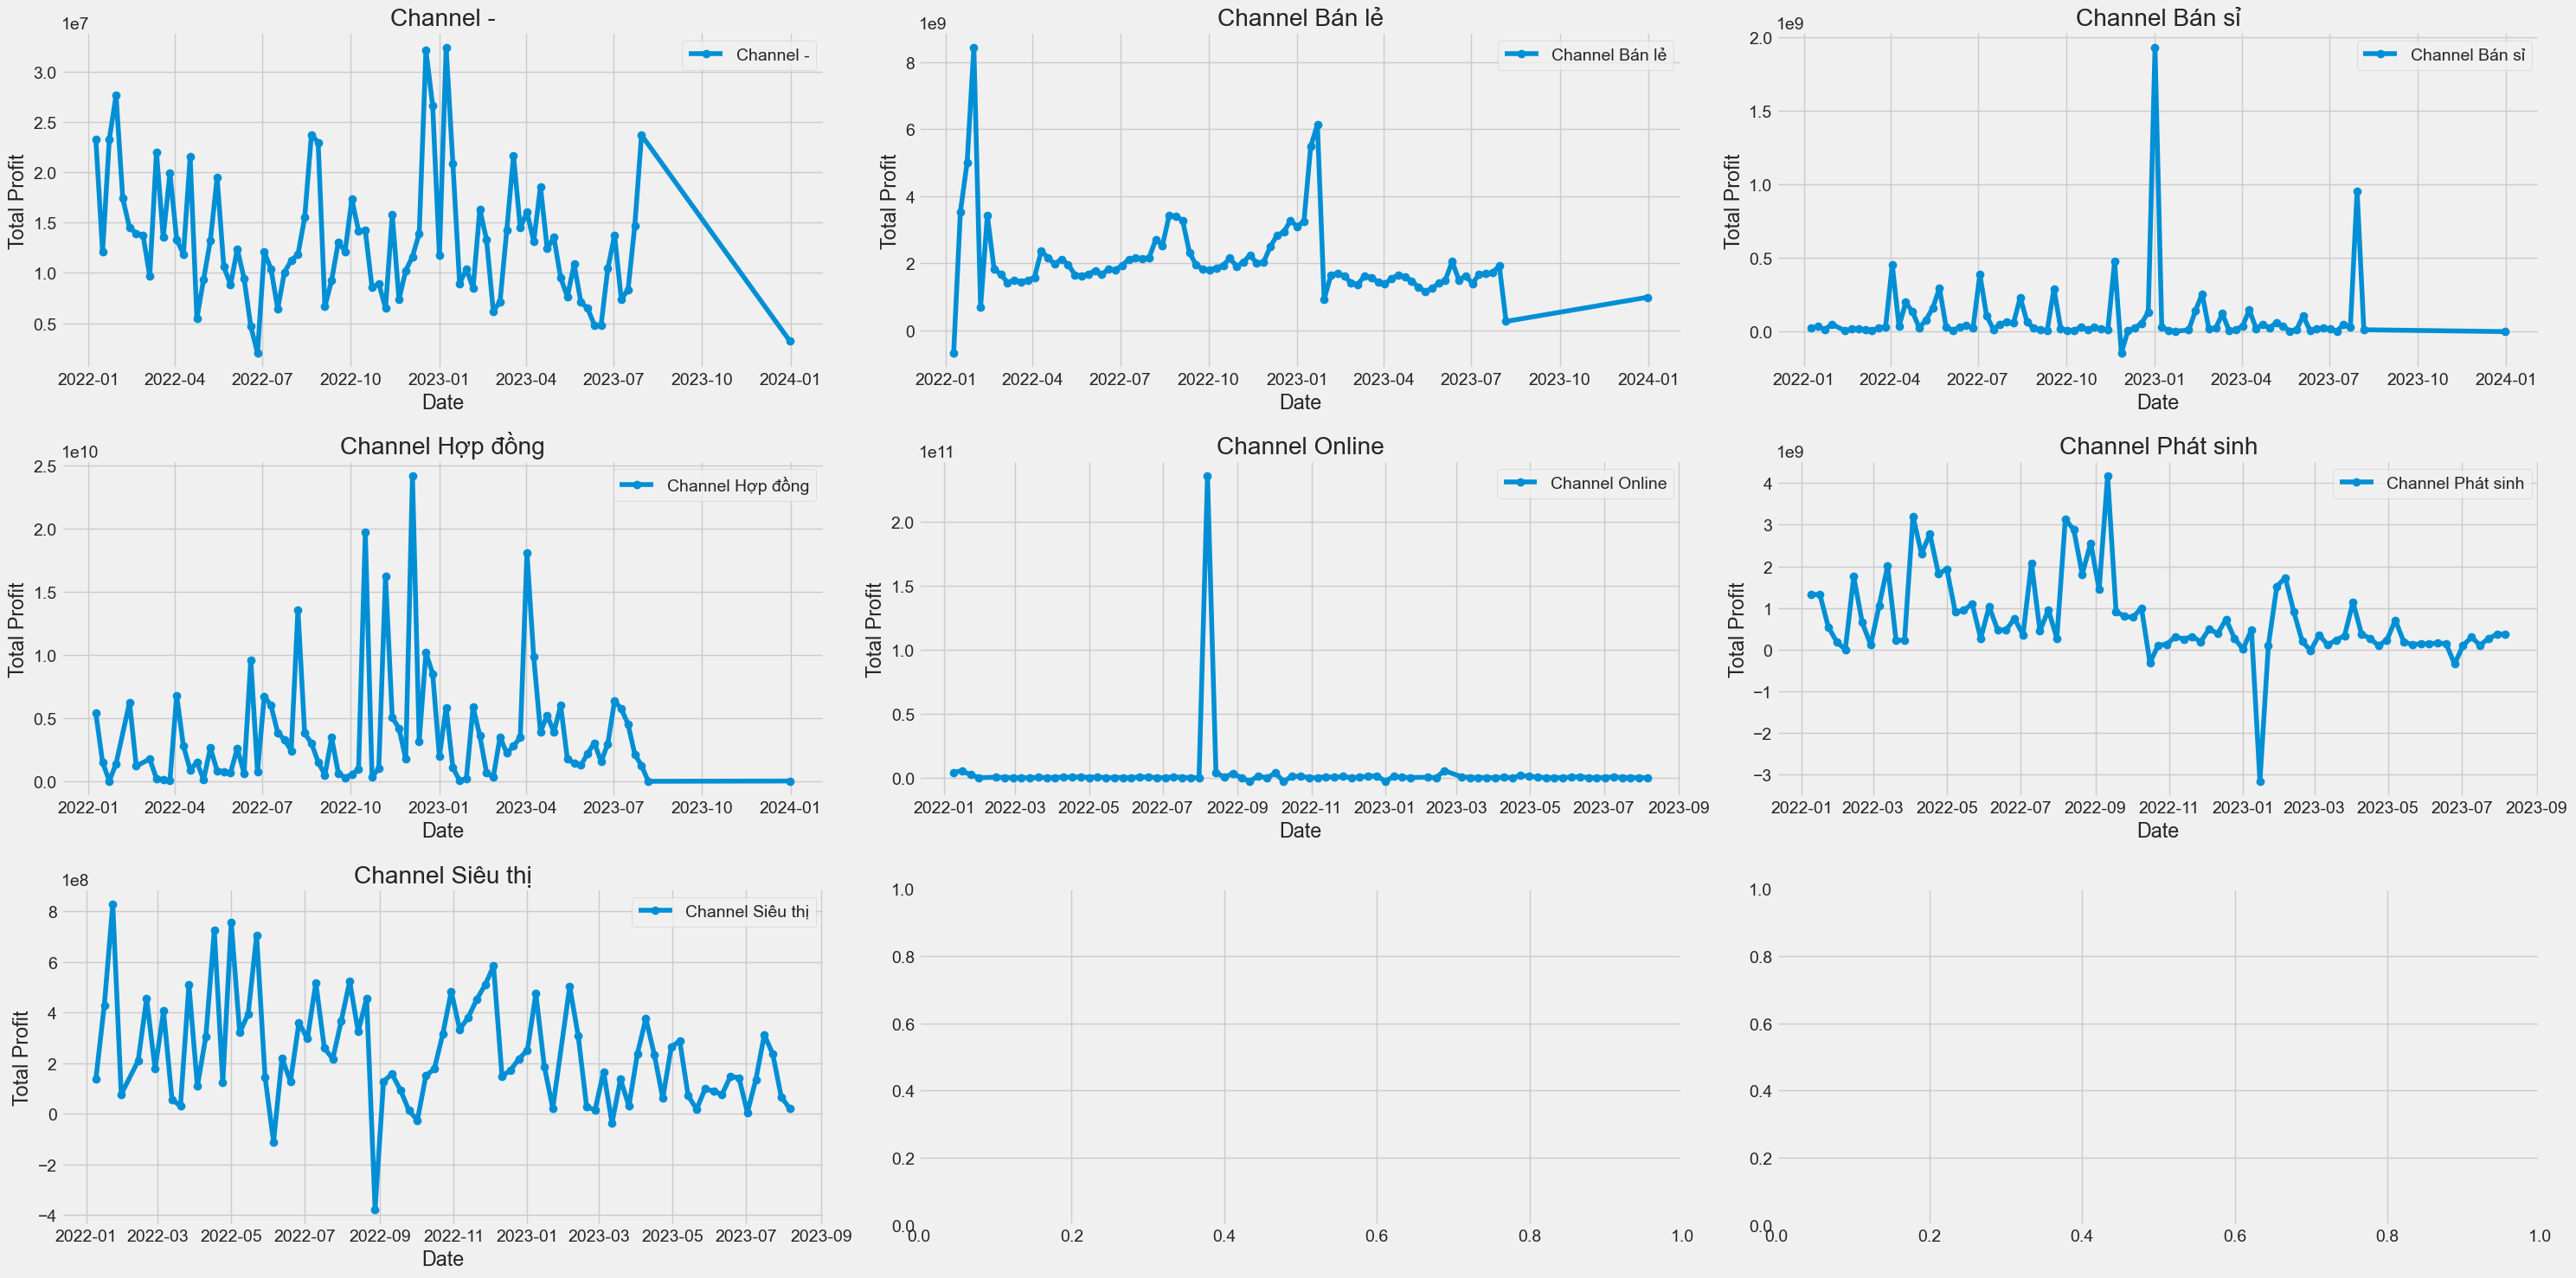

In [26]:
total_profit_over_time = sales_data.groupby(['date', 'distribution_channel'])['profit'].sum().reset_index()

fig, axs = plt.subplots(3, 3, figsize=(30, 15))
axs = axs.ravel()

# Plot a line for each distribution_channel
for i, channel in enumerate(total_profit_over_time['distribution_channel'].unique()):
    data = total_profit_over_time[total_profit_over_time['distribution_channel'] == channel]
    axs[i].plot(data['date'], data['profit'], marker='o', label=f'Channel {channel}')
    axs[i].set_title(f'Channel {channel}')
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Total Profit')
    axs[i].grid(True)
    axs[i].legend()

plt.tight_layout()
plt.show()

### **Data Modeling**

#### **ARIMA Model**

Channel CHTT Test Mean Squared Error: 0.016469524920891015
Channel ONLINE Test Mean Squared Error: 0.000674239645843017
Channel ST Test Mean Squared Error: 0.021337037238718763
Channel TGPP Test Mean Squared Error: 0.03484050226058958


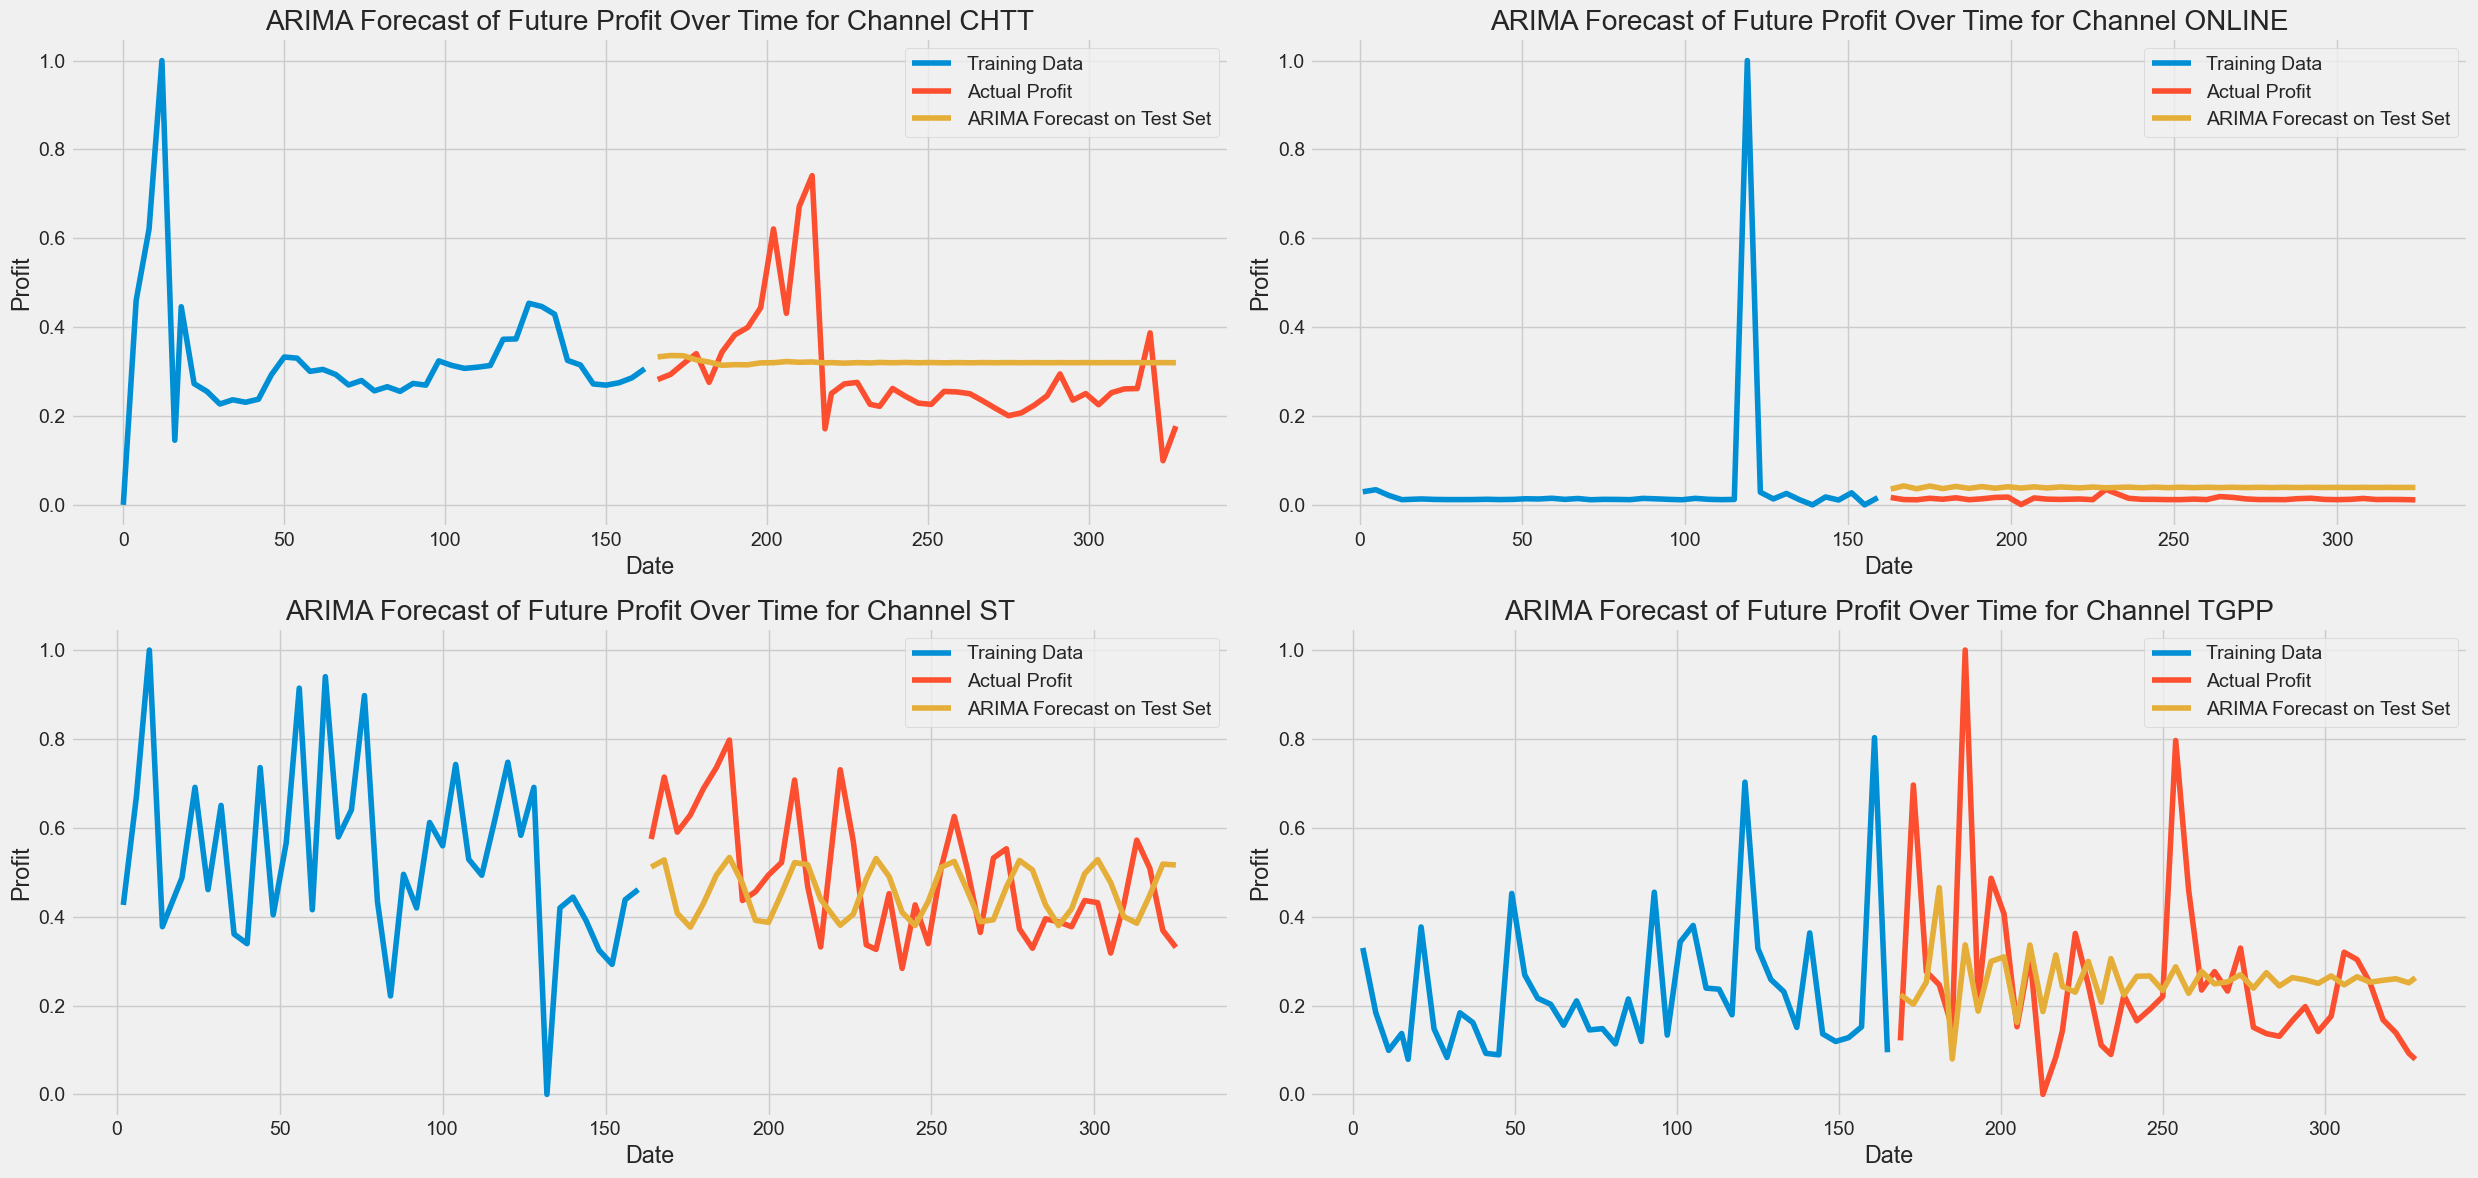

In [33]:
scaler = MinMaxScaler()

fig, axs = plt.subplots(2, 2, figsize=(25, 12))
axs = axs.ravel()

# Loop over each unique channel_id
for i, channel in enumerate(total_profit_over_time['channel_id'].unique()):
    data = total_profit_over_time[total_profit_over_time['channel_id'] == channel]
    data['profit'] = scaler.fit_transform(data[['profit']])

    # Split the data into training and testing sets
    train_size = int(len(data) * 0.5)
    train, test = data[:train_size], data[train_size:]

    # Build and fit the ARIMA model on the training set
    model = ARIMA(train['profit'], order=(5, 1, 2))  # Adjust order as needed
    fit_model = model.fit()

    # Forecast future values on the test set
    forecast_values_test = fit_model.forecast(steps=len(test))

    # Evaluate the model on the test set
    mse_test = mean_squared_error(test['profit'], forecast_values_test)
    print(f'Channel {channel} Test Mean Squared Error: {mse_test}')

    # Visualize the results
    axs[i].plot(train.index, train['profit'], label='Training Data')
    axs[i].plot(test.index, test['profit'], label='Actual Profit')
    axs[i].plot(test.index, forecast_values_test, label='ARIMA Forecast on Test Set')
    axs[i].set_title(f'ARIMA Forecast of Future Profit Over Time for Channel {channel}')
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Profit')
    axs[i].legend()

plt.tight_layout()
plt.show()

#### **SARIMAX Model**

Channel CHTT Test Mean Squared Error: 0.03416768858893874
Channel ONLINE Test Mean Squared Error: 0.12411866850021014
Channel ST Test Mean Squared Error: 0.2148098976341256
Channel TGPP Test Mean Squared Error: 0.08245067830272135


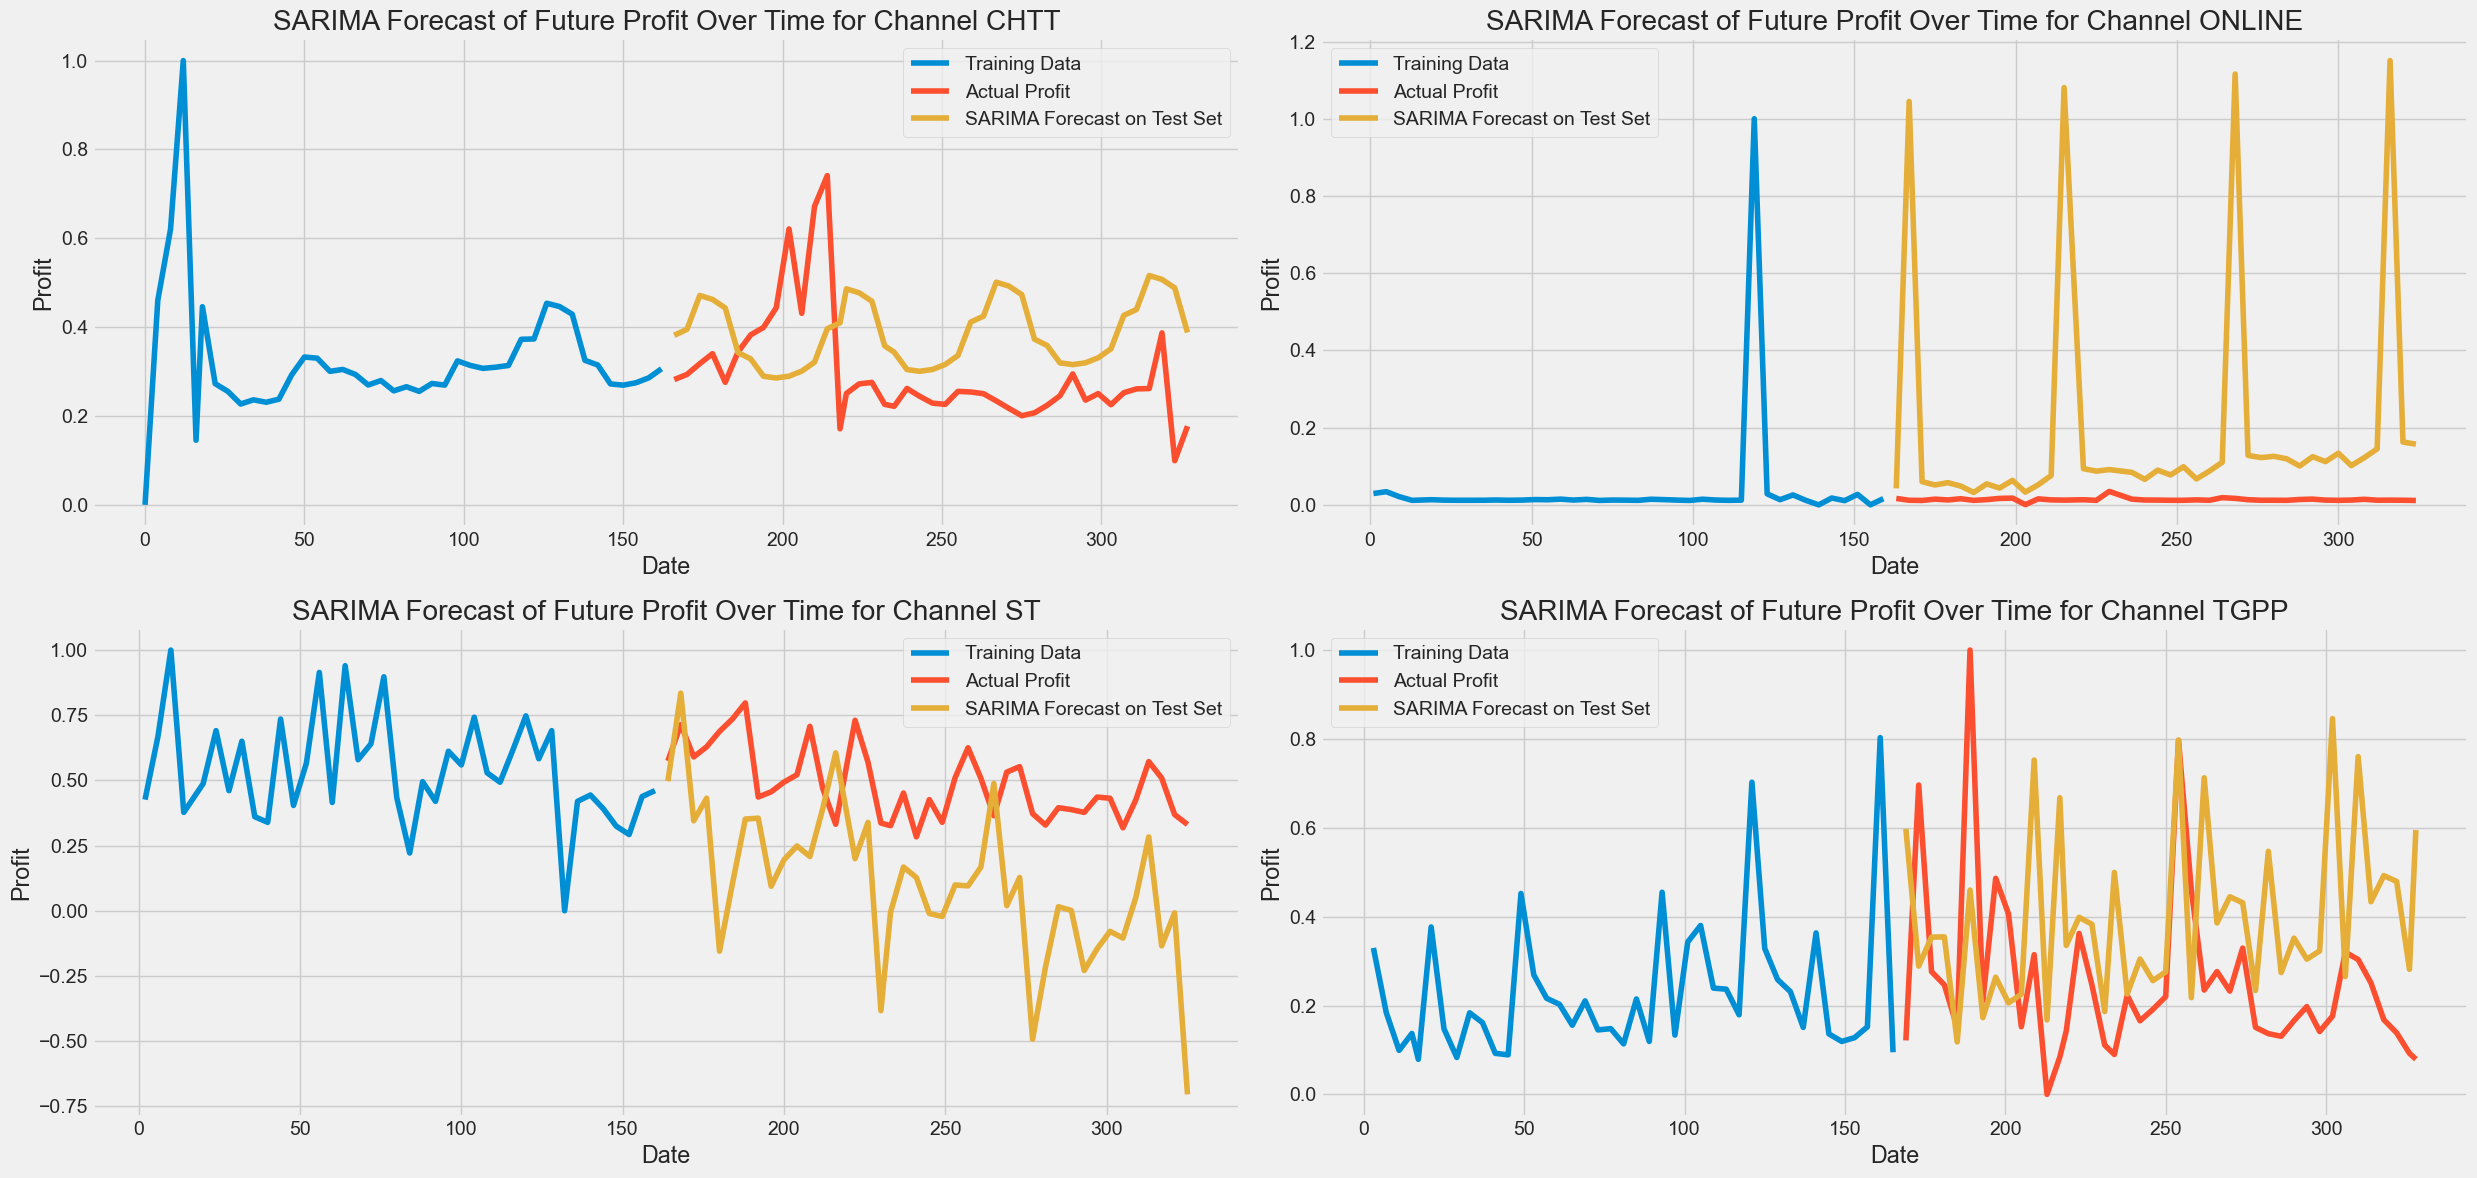

In [35]:

scaler = MinMaxScaler()

fig, axs = plt.subplots(2, 2, figsize=(25, 12))
axs = axs.ravel()

# Loop over each unique channel_id
for i, channel in enumerate(total_profit_over_time['channel_id'].unique()):
    data = total_profit_over_time[total_profit_over_time['channel_id'] == channel]
    data['profit'] = scaler.fit_transform(data[['profit']])

    # Split the data into training and testing sets
    train_size = int(len(data) * 0.5)
    train, test = data[:train_size], data[train_size:]

    # Build and fit the SARIMA model on the training set
    model = SARIMAX(train['profit'], order=(5, 1, 2), seasonal_order=(0, 1, 1, 12))
    fit_model = model.fit()

    # Forecast future values on the test set
    forecast_values_test = fit_model.forecast(steps=len(test))

    # Evaluate the model on the test set
    mse_test = mean_squared_error(test['profit'], forecast_values_test)
    print(f'Channel {channel} Test Mean Squared Error: {mse_test}')

    # Visualize the results
    axs[i].plot(train.index, train['profit'], label='Training Data')
    axs[i].plot(test.index, test['profit'], label='Actual Profit')
    axs[i].plot(test.index, forecast_values_test, label='SARIMA Forecast on Test Set')
    axs[i].set_title(f'SARIMA Forecast of Future Profit Over Time for Channel {channel}')
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Profit')
    axs[i].legend()

plt.tight_layout()
plt.show()

#### **LSTM Model**

2/2 [==============================] - 0s 4ms/step
Channel CHTT Test Mean Squared Error: 0.004326709273722027
2/2 [==============================] - 0s 4ms/step
Channel ONLINE Test Mean Squared Error: 0.0002411087712150717
2/2 [==============================] - 0s 5ms/step
Channel ST Test Mean Squared Error: 0.004161830096532838
2/2 [==============================] - 0s 4ms/step
Channel TGPP Test Mean Squared Error: 0.0005185779485897107


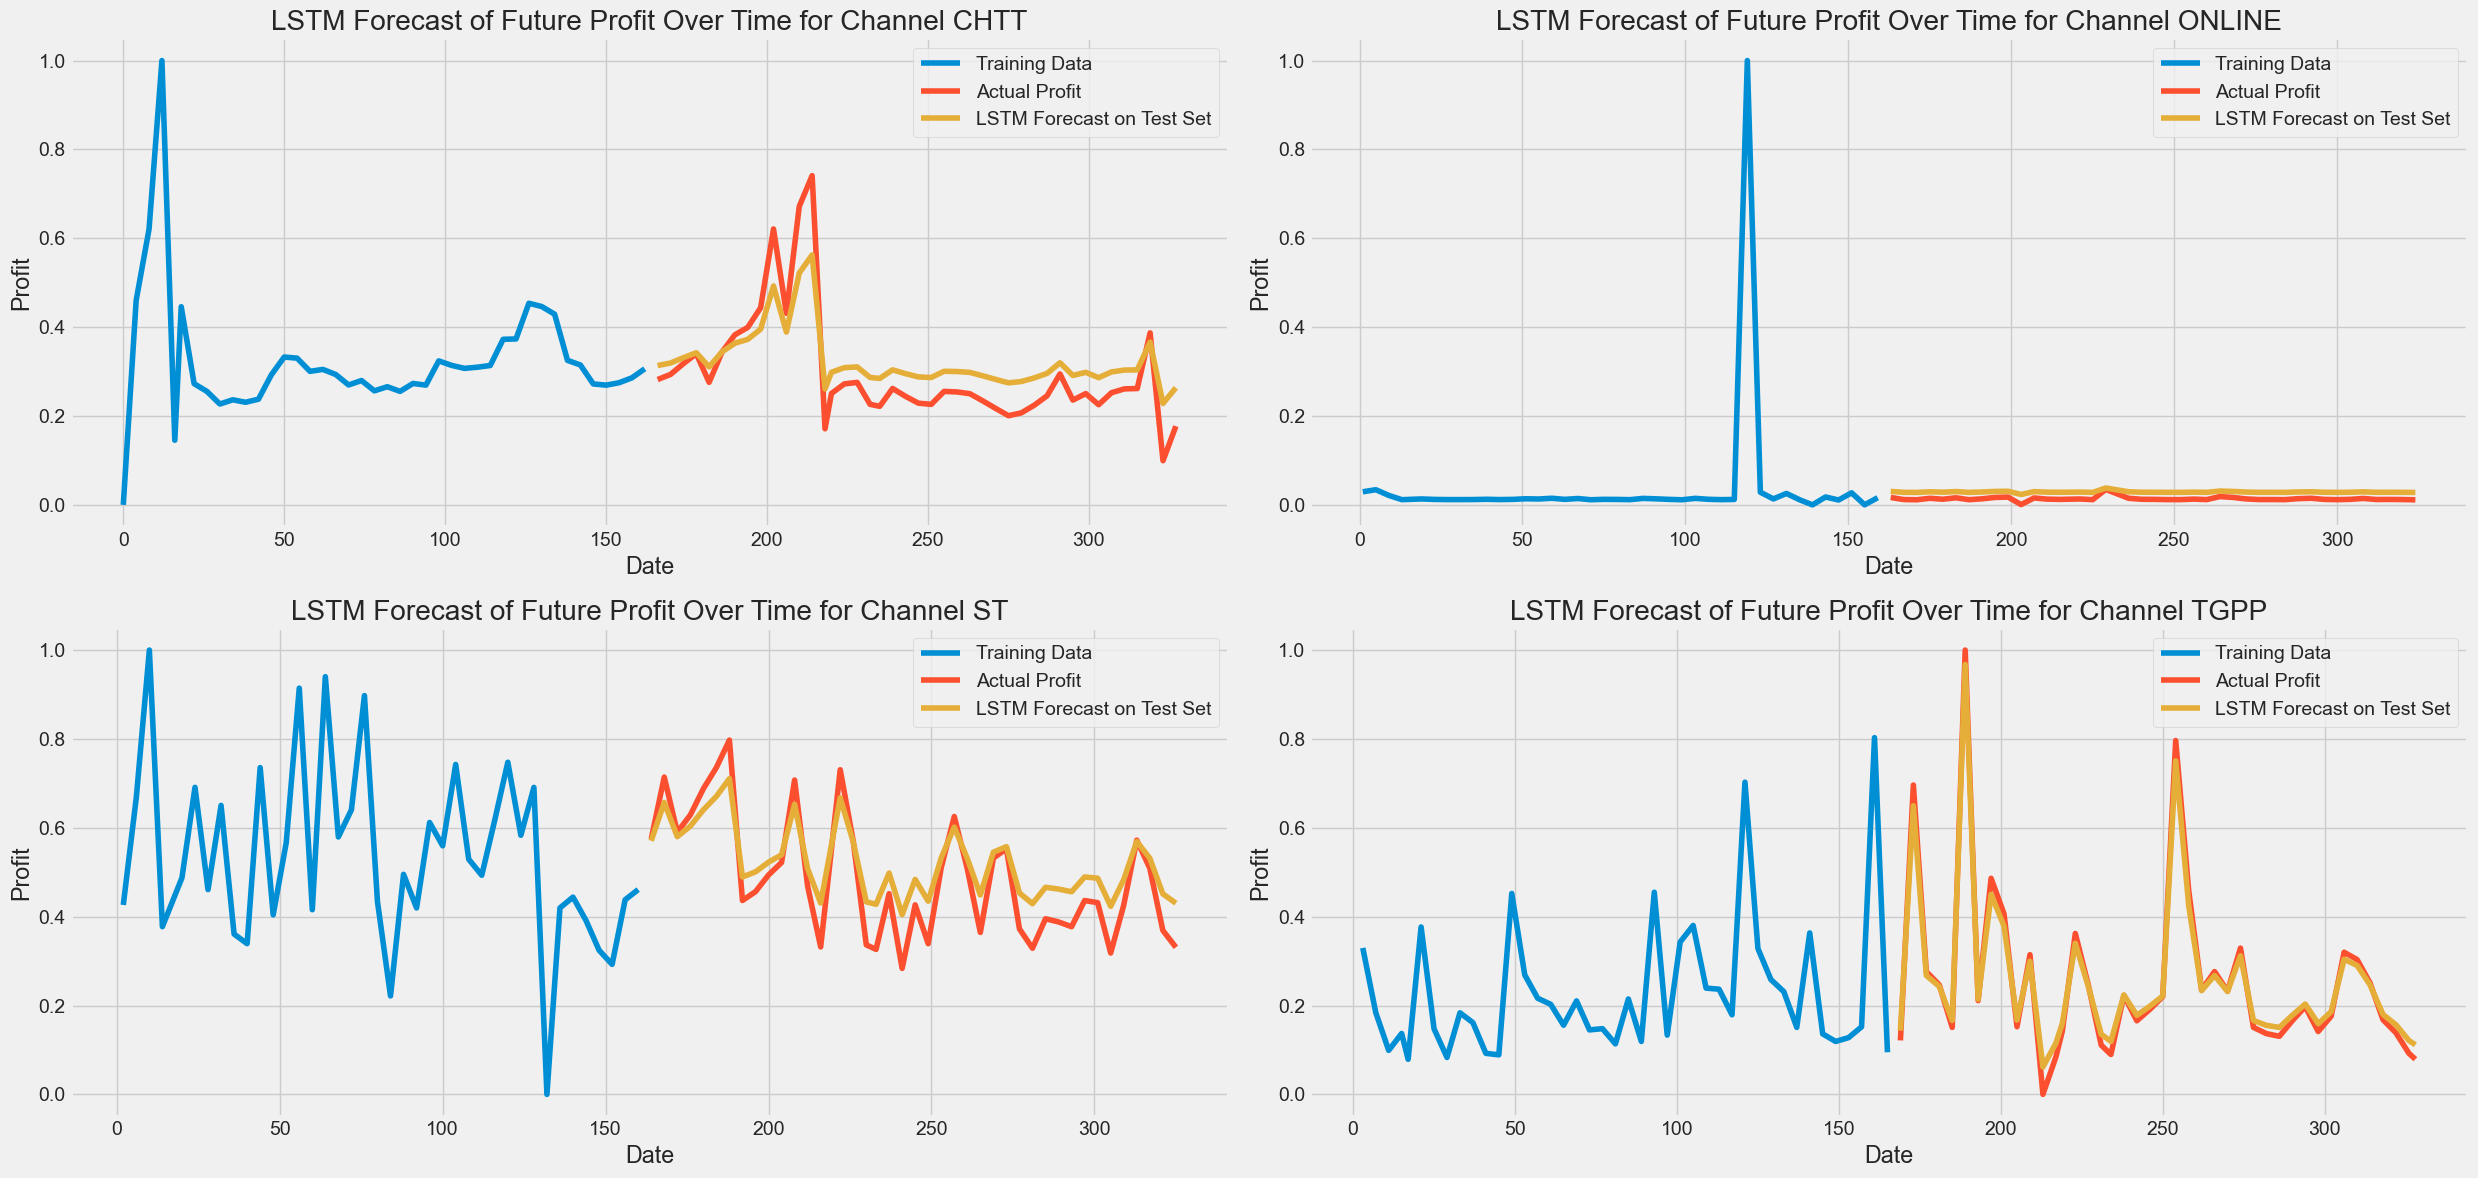

In [36]:
scaler = MinMaxScaler()

fig, axs = plt.subplots(2, 2, figsize=(25, 12))
axs = axs.ravel()

# Loop over each unique channel_id
for i, channel in enumerate(total_profit_over_time['channel_id'].unique()):
    data = total_profit_over_time[total_profit_over_time['channel_id'] == channel]
    data['profit'] = scaler.fit_transform(data[['profit']])

    # Split the data into training and testing sets
    train_size = int(len(data) * 0.5)
    train, test = data[:train_size], data[train_size:]

    # Reshape the data to be 3D, as expected by the LSTM layer
    train_values = np.array(train['profit']).reshape(-1, 1, 1)
    test_values = np.array(test['profit']).reshape(-1, 1, 1)

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(1, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Fit the model on the training set
    model.fit(train_values, train['profit'], epochs=200, verbose=0)

    # Forecast future values on the test set
    forecast_values_test = model.predict(test_values)

    # Evaluate the model on the test set
    mse_test = mean_squared_error(test['profit'], forecast_values_test)
    print(f'Channel {channel} Test Mean Squared Error: {mse_test}')

    # Visualize the results
    axs[i].plot(train.index, train['profit'], label='Training Data')
    axs[i].plot(test.index, test['profit'], label='Actual Profit')
    axs[i].plot(test.index, forecast_values_test, label='LSTM Forecast on Test Set')
    axs[i].set_title(f'LSTM Forecast of Future Profit Over Time for Channel {channel}')
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Profit')
    axs[i].legend()

plt.tight_layout()
plt.show()

In [70]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

one_hot_encoder = OneHotEncoder()
label_encoder = LabelEncoder()

# Apply One Hot Encoding
one_hot_cols = ['channel_id', 'distribution_channel']
for col in one_hot_cols:
    sales_data = pd.concat([sales_data, pd.get_dummies(sales_data[col], prefix=col)], axis=1)
    sales_data.drop(col, axis=1, inplace=True)

# Apply Label Encoding
label_cols = ['distribution_channel_code', 'customer_id', 'product_id']
for col in label_cols:
    sales_data[col] = label_encoder.fit_transform(sales_data[col])

In [71]:
cols_to_convert = sales_data.filter(regex='^(channel_id|distribution_channel)').columns

for col in cols_to_convert:
    sales_data[col] = sales_data[col].astype('int64')

In [72]:
sales_data.columns

Index(['site', 'branch_id', 'distribution_channel_code', 'sold_quantity',
       'cost_price', 'net_price', 'customer_id', 'product_id', 'total_sales',
       'date', 'total_cost', 'profit', 'channel_id_CHTT', 'channel_id_ONLINE',
       'channel_id_ST', 'channel_id_TGPP', 'distribution_channel_-',
       'distribution_channel_Bán lẻ', 'distribution_channel_Bán sỉ',
       'distribution_channel_Hợp đồng', 'distribution_channel_Online',
       'distribution_channel_Phát sinh', 'distribution_channel_Siêu thị'],
      dtype='object')

In [73]:
sales_data.dtypes

site                                       int64
branch_id                                  int64
distribution_channel_code                  int64
sold_quantity                              int64
cost_price                                 int64
net_price                                  int64
customer_id                                int32
product_id                                 int32
total_sales                                int64
date                              datetime64[ns]
total_cost                                 int64
profit                                     int64
channel_id_CHTT                            int64
channel_id_ONLINE                          int64
channel_id_ST                              int64
channel_id_TGPP                            int64
distribution_channel_-                     int64
distribution_channel_Bán lẻ                int64
distribution_channel_Bán sỉ                int64
distribution_channel_Hợp đồng              int64
distribution_channel

In [77]:
y = sales_data['profit']
X = sales_data.drop(['profit', 'date'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# create a list of models to evaluate
models = []
models.append(('LR', LinearRegression()))
models.append(('XGB', XGBRegressor()))

In [78]:
results = []
names = []
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    results.append(cv_results)
    names.append(name)
    print(f"{name}: {cv_results.mean()} ({cv_results.std()})")

LR: 0.9673652719971306 (0.0266780871580602)
XGB: 0.36617995550900134 (0.3002620282865318)


### **HyperParameter Tunning**

In [ ]:
param_grid = {
    'learning_rate': [0.05, 0.007, 0.1, 0.15],
    'n_estimators': [500, 750, 100],
}

grid_search = GridSearchCV( 
    XGBRegressor(),
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error'
)

grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'learning_rate': 0.15, 'n_estimators': 750}


In [ ]:
print("Best Model's Parameters: ", grid_search.best_params_)

# evaluate the best model on the test set
y_pred = grid_search.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Best Model's RMSE on Test Set: {rmse}")

Best Model's Parameters:  {'learning_rate': 0.15, 'n_estimators': 750}
Best Model's RMSE on Test Set: 4998435.33248536


In [ ]:
r2_test = r2_score(y_test,y_pred)
print("R Squared Value : ",r2_test)

R Squared Value :  0.7952122477214649


In [ ]:
model = XGBRegressor(n_estimators = 750,learning_rate = 0.15)
model.fit(X_train,y_train)
# trainning data prediction
y_pred = model.predict(X_test)

# R squared value
r2_test = r2_score(y_test,y_pred)
print("R Squared Value : ",r2_test)

R Squared Value :  0.7952122477214649


### **Inventory data area**

Inventory data includes multiple files representing information on inventory management across plants (stocks), the data is collected between 2022 and 2023 at the end of every two months. The file follow the format

`<date>-<month>-<year>_Ton Kho <start_plant_id>-<end_plant_id>.xlsx`

Where

`<date>-<month>-<year>` represents the date that inventory data is collected

`<start_plant_id>-<end_plant_id>` represents the range of plants (stocks) id in the files.

For instance, the file “31-10-2022_Ton Kho 1161-1170.xlsx” represents the inventory management data collected at the end of October in the stocks having IDs from 1161 to 1170

Each file includes the following data fields:

- plant: the id of plant/stock
- calendar_year: year
- calendar_yeer_week: week in year
- sloc: site location
- quantity: represents the overall inventory quantity of products
- total_amount: a total of monetary values
- product_id: represents the product ID

In [ ]:
inventory_files = glob.glob("Inventory_mentor/*-*-*_Ton Kho *.xlsx")
inventory_df = pd.DataFrame()

for file in inventory_files:
    df = pd.read_excel(file, index_col=None)
    inventory_df = pd.concat([inventory_df, df], ignore_index=True)
    
inventory_df = inventory_df.drop(columns=['Unnamed: 0', 'index'])

In [ ]:
inventory_df

,plant,calendar_year,calendar_yeer_week,sloc,quantity,total_amount,product_id
0,1101,2022,20220228,3000,17,17000.0,1259098aaa8e447181f13903f84e5db1OOO35
1,1101,2022,20220228,3000,48,34000.0,39b38616e4d649ab9c3b7d04e82e079fOOO36
2,1101,2022,20220228,3000,87,0.0,8db14e88898e40a392f80ed69c30e206OOO37
3,1101,2022,20220228,3000,80,-34000.0,7c15de90afd343338f93c8f65a0d8380OOO38
4,1101,2022,20220228,3000,128,68000.0,6c04a173aec34690b242ed4e09367e96OOO39
...,...,...,...,...,...,...,...
4008718,2001,2022,20221231,3000,1,0.0,52de17c640cc4085a863cf9d18ddeb6fNAU35
4008719,2001,2022,20221231,3000,1,0.0,267a3bb60d1d4fe8bfeb53107482914fNAU36
4008720,2001,2022,20221231,3000,2,0.0,8aab639678b84044a99fa92cab5203aaNAU37
4008721,2001,2022,20221231,3000,2,0.0,f9bfb859e6c846a086ed6985ba6b7c74NAU38


In [ ]:
inventory_df[inventory_df['quantity'] <= 0]

,plant,calendar_year,calendar_yeer_week,sloc,quantity,total_amount,product_id
439402,1264,2023,20230228,3000,0,0.0,4fdbf080b6ad48a28ae2fc67d950ffb2XAM33
1310565,1264,2022,20220930,3000,0,0.0,4fdbf080b6ad48a28ae2fc67d950ffb2XAM33
2227531,1264,2023,20230131,3000,0,0.0,4fdbf080b6ad48a28ae2fc67d950ffb2XAM33


In [ ]:
unique_values = inventory_df['calendar_yeer_week'].unique()

unique_values

[20220228 20230228 20220430 20230430 20220630 20220930 20221130 20220131
 20230131 20220331 20230331 20220531 20220731 20220831 20221031 20221231]


In [ ]:
inventory_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4008723 entries, 0 to 4008722
Data columns (total 7 columns):
 #   Column              Dtype  
---  ------              -----  
 0   plant               int64  
 1   calendar_year       int64  
 2   calendar_yeer_week  int64  
 3   sloc                object 
 4   quantity            int64  
 5   total_amount        float64
 6   product_id          object 
dtypes: float64(1), int64(4), object(2)
memory usage: 214.1+ MB


In [ ]:
inventory_df.describe()

,plant,calendar_year,calendar_yeer_week,quantity,total_amount
count,4.008723e+06,4.008723e+06,4.008723e+06,4.008723e+06,4.008723e+06
mean,1.313195e+03,2.022167e+03,2.022226e+07,2.293053e+00,5.070792e+04
std,2.040280e+02,3.725753e-01,3.577873e+03,1.180283e+01,7.159304e+06
min,1.100000e+03,2.022000e+03,2.022013e+07,0.000000e+00,-9.578056e+08
25%,1.148000e+03,2.022000e+03,2.022043e+07,1.000000e+00,0.000000e+00
50%,1.241000e+03,2.022000e+03,2.022083e+07,1.000000e+00,0.000000e+00
75%,1.507000e+03,2.022000e+03,2.022123e+07,2.000000e+00,0.000000e+00
max,2.001000e+03,2.023000e+03,2.023043e+07,7.403000e+03,2.466819e+09


In [ ]:
num_missing = inventory_df.isnull().sum().sum()

print(f'Number of missing values: {num_missing}')

Number of missing values: 0


In [ ]:
inventory_df['calendar_yeer_week'] = pd.to_datetime(inventory_df['calendar_yeer_week'])

In [ ]:
inventory_df['calendar_yeer_week']

0         1970-01-01 00:00:00.020220228
1         1970-01-01 00:00:00.020220228
2         1970-01-01 00:00:00.020220228
3         1970-01-01 00:00:00.020220228
4         1970-01-01 00:00:00.020220228
                       ...             
4008718   1970-01-01 00:00:00.020221231
4008719   1970-01-01 00:00:00.020221231
4008720   1970-01-01 00:00:00.020221231
4008721   1970-01-01 00:00:00.020221231
4008722   1970-01-01 00:00:00.020221231
Name: calendar_yeer_week, Length: 4008723, dtype: datetime64[ns]

#### **Some EDA about `Inventory data area`**

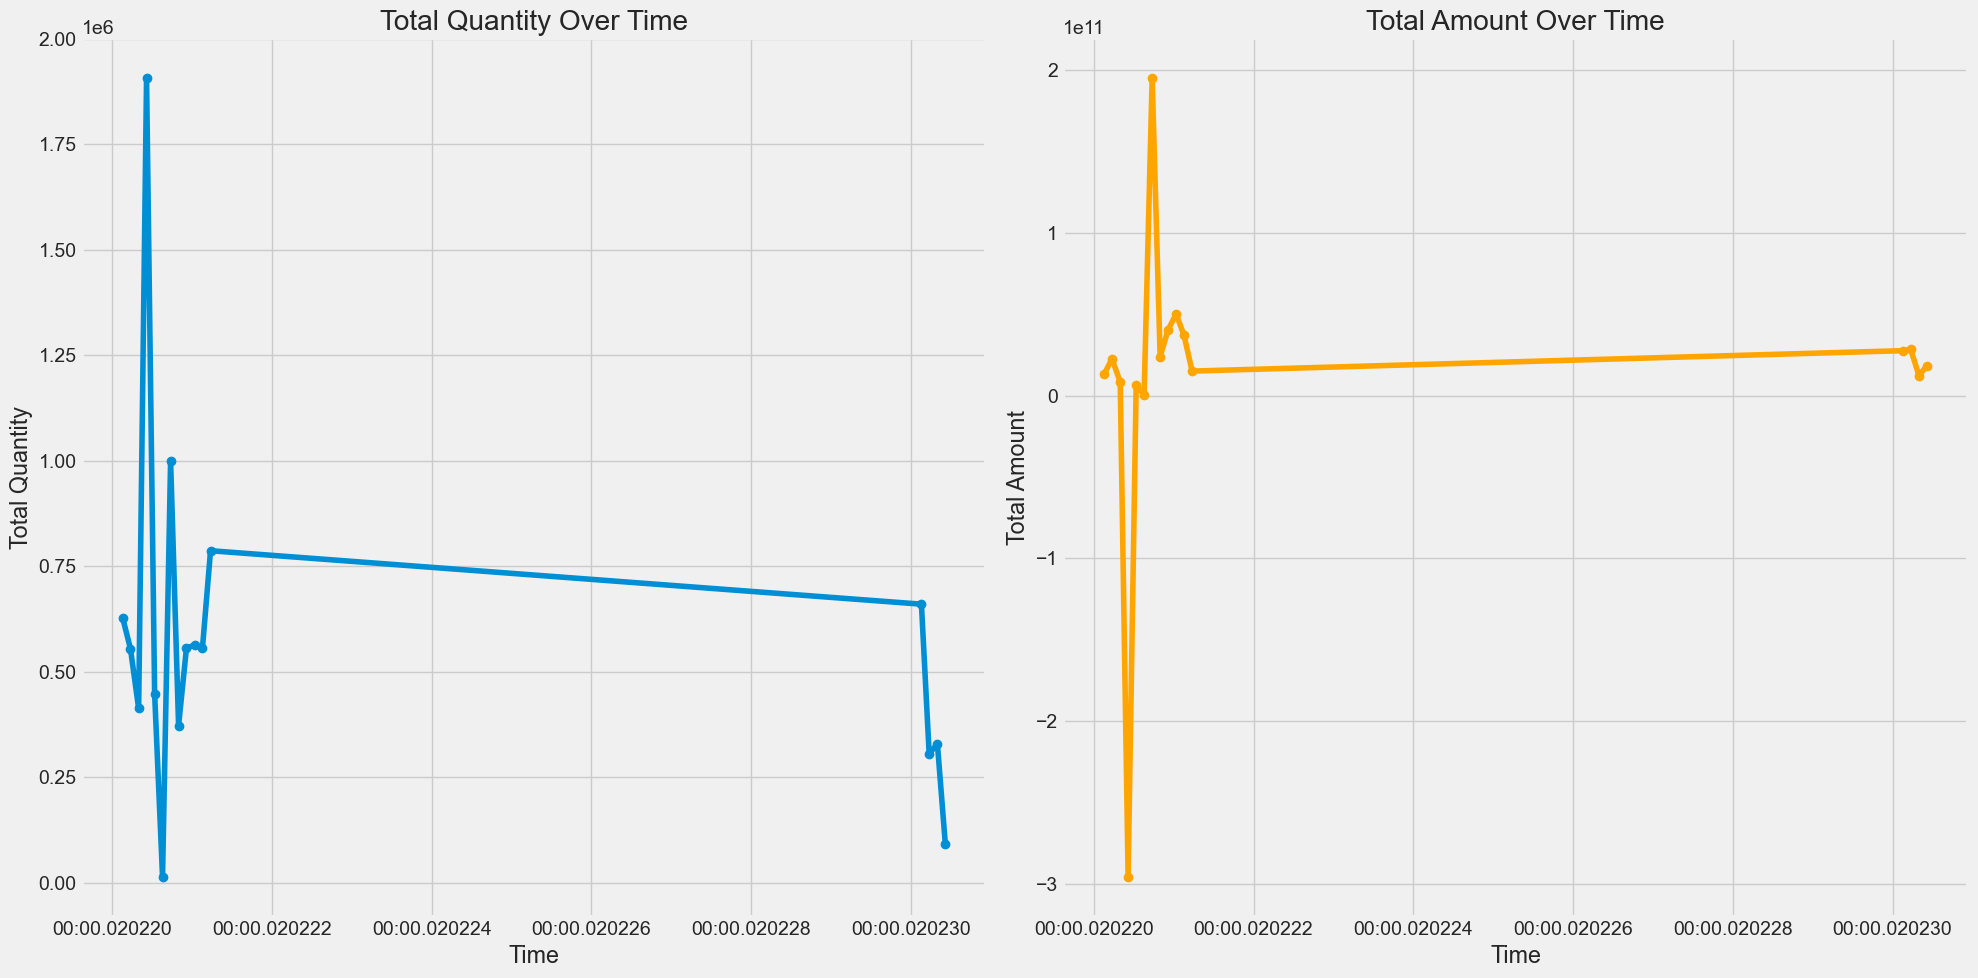

In [ ]:
total_quantity_over_year = inventory_df.groupby('calendar_yeer_week')['quantity'].sum().reset_index()
total_amount_over_year = inventory_df.groupby('calendar_yeer_week')['total_amount'].sum().reset_index()

# Plotting
plt.figure(figsize=(20, 10))

# Total Quantity Over the Year
plt.subplot(1, 2, 1)
plt.plot(total_quantity_over_year['calendar_yeer_week'], total_quantity_over_year['quantity'], marker='o')
plt.title('Total Quantity Over Time')
plt.xlabel('Time')
plt.ylabel('Total Quantity')

# Total Amount Over the Year
plt.subplot(1, 2, 2)
plt.plot(total_amount_over_year['calendar_yeer_week'], total_amount_over_year['total_amount'], marker='o', color='orange')
plt.title('Total Amount Over Time')
plt.xlabel('Time')
plt.ylabel('Total Amount')

plt.tight_layout()
plt.show()

### **Productmaster.xlsx**

- color: Product colors by gender category
- color group: similar color groups
- listing_price: detail price of each product
- price_group: different price groups can influence consumer decisions
- gender: The product users are classified by gender and age
- product_group: Group of products with similar characteristics in terms of design and structure
- detail_product_group: Group of product types with similar characteristics in terms of design and structure.
- shoe_product: Group of shoe product details with similar characteristics in terms of material
- size_group: main frame sizes by gender group or special and exceptional frames
- size: Size of each individual product detail
- age_group: Age groups with different preferences and comsumer behaviors
- activity_group: A collection of activities with similar usage purposes
- image_copyright: Detailed copyright character name
- lifestyle_group: the fashion styles that comsumers aspire to when choosing products
- launch_season: the time period during
- mold_code: information about the product’s heel code
- heel_height: group of products with a common heel height
- option: a collection of product codes with similar details
- cost_price: includes all the expenses associated with producing or acquiring a product
- product_id: represents the product ID
- product_style_color: represents the style color of a product
- product_style: represents the style color of a product
- brand_name: name of the branch
- vendor_name: name of the vendor

In [ ]:
product_detail_df = pd.read_excel('MasterData/Productmaster.xlsx', index_col=None)
product_detail_df = product_detail_df.drop(columns=['Unnamed: 0', 'index'])

In [ ]:
product_detail_df

,color,color_group,listing_price,price_group,gender,product_group,detail_product_group,shoe_product,size_group,size,...,name_description,mch_description,code_lock,option,cost_price,product_id,product_syle_color,product_syle,brand_name,vendor_name
0,DEN,TỐI,255273.0,200<300,MEN,SAN,SANTD,STT,Ngoại lệ,38.0,...,Khóa mã theo TB022 P.ĐH&ĐPTT,NHÓM HÀNG CHẬM,x,P03-C05,176800.0,80e1107e5bf74598baffea3a7b6073c5DEN38,80e1107e5bf74598baffea3a7b6073c5DEN,80e1107e5bf74598baffea3a7b6073c5,Brand1,vendor0
1,DEN,TỐI,255273.0,200<300,MEN,SAN,SANTD,STT,Ngoại lệ,39.0,...,Khóa mã theo TB022 P.ĐH&ĐPTT,NHÓM HÀNG CHẬM,x,P03-C05,176800.0,c8223e6133a64491a006dc0f95c2bfd9DEN39,c8223e6133a64491a006dc0f95c2bfd9DEN,c8223e6133a64491a006dc0f95c2bfd9,Brand1,vendor0
2,DEN,TỐI,255273.0,200<300,MEN,SAN,SANTD,STT,Ngoại lệ,40.0,...,Khóa mã theo TB022 P.ĐH&ĐPTT,NHÓM HÀNG CHẬM,x,P03-C05,176800.0,bec30e131ee04e49a4c87bc56f135b13DEN40,bec30e131ee04e49a4c87bc56f135b13DEN,bec30e131ee04e49a4c87bc56f135b13,Brand1,vendor0
3,DEN,TỐI,255273.0,200<300,MEN,SAN,SANTD,STT,Ngoại lệ,41.0,...,Khóa mã theo TB022 P.ĐH&ĐPTT,NHÓM HÀNG CHẬM,x,P03-C05,176800.0,3f4e265b0ac740e9b9edfd23e0ba1ca5DEN41,3f4e265b0ac740e9b9edfd23e0ba1ca5DEN,3f4e265b0ac740e9b9edfd23e0ba1ca5,Brand1,vendor0
4,DEN,TỐI,255273.0,200<300,MEN,SAN,SANTD,STT,Ngoại lệ,42.0,...,Khóa mã theo TB022 P.ĐH&ĐPTT,NHÓM HÀNG CHẬM,x,P03-C05,176800.0,53e6284597944ec787e002b631391210DEN42,53e6284597944ec787e002b631391210DEN,53e6284597944ec787e002b631391210,Brand1,vendor0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94862,CAM,TỐI,NaN,NaN,MEN,PKI,PKIEN,PKG,Đặc biệt,35.0,...,"các loại phụ kiện, Cam, 35",NHÓM PHỤ KIỆN,NaN,0,NaN,00cb29b5c14f4b22a90b4fd804e2d498CAM35,00cb29b5c14f4b22a90b4fd804e2d498CAM,00cb29b5c14f4b22a90b4fd804e2d498,Brand2,vendor0
94863,CAM,TỐI,NaN,NaN,MEN,PKI,PKIEN,PKG,Đặc biệt,37.0,...,"các loại phụ kiện, Cam, 37",NHÓM PHỤ KIỆN,NaN,0,NaN,0980b5ae05be404e8d3cd627f77371c2CAM37,0980b5ae05be404e8d3cd627f77371c2CAM,0980b5ae05be404e8d3cd627f77371c2,Brand2,vendor0
94864,CAM,TỐI,NaN,NaN,MEN,PKI,PKIEN,PKG,Đặc biệt,39.0,...,"các loại phụ kiện, Cam, 39",NHÓM PHỤ KIỆN,NaN,0,NaN,ee6cd28b3ad547b1ba97f389da5b6220CAM39,ee6cd28b3ad547b1ba97f389da5b6220CAM,ee6cd28b3ad547b1ba97f389da5b6220,Brand2,vendor0
94865,CAM,TỐI,NaN,NaN,MEN,PKI,PKIEN,PKG,Đặc biệt,41.0,...,"các loại phụ kiện, Cam, 41",NHÓM PHỤ KIỆN,NaN,0,NaN,c4ec68c1036348cd8feb1a58c6adeddaCAM41,c4ec68c1036348cd8feb1a58c6adeddaCAM,c4ec68c1036348cd8feb1a58c6adedda,Brand2,vendor0


In [ ]:
product_detail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94867 entries, 0 to 94866
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   color                 94822 non-null  object 
 1   color_group           94867 non-null  object 
 2   listing_price         94840 non-null  float64
 3   price_group           94840 non-null  object 
 4   gender                94867 non-null  object 
 5   product_group         94867 non-null  object 
 6   detail_product_group  94867 non-null  object 
 7   shoe_product          94867 non-null  object 
 8   size_group            94867 non-null  object 
 9   size                  94722 non-null  float64
 10  age_group             94867 non-null  object 
 11  activity_group        94867 non-null  object 
 12  collection            94862 non-null  object 
 13  image_copyright       94867 non-null  object 
 14  product_line          94867 non-null  object 
 15  lifestyle_group    

### Feature Engineering

In [ ]:
product_detail_df['gender'] = product_detail_df['gender'].replace({'BOY': 'MEN', 'GIR': 'WOM'})

In [ ]:
product_detail_df['profit'] = product_detail_df['listing_price'] - product_detail_df['cost_price']
product_detail_df['profit']

0        78473.0
1        78473.0
2        78473.0
3        78473.0
4        78473.0
          ...   
94862        NaN
94863        NaN
94864        NaN
94865        NaN
94866        NaN
Name: profit, Length: 94867, dtype: float64

In [ ]:
num_nan = product_detail_df.isna().sum().sum()

print(f'Number of NaN values: {num_nan}')

num_missing = product_detail_df.isnull().sum().sum()

print(f'Number of missing values: {num_missing}')

Number of NaN values: 141902
Number of missing values: 141902


In [ ]:
missing_values = product_detail_df.isnull().sum()

# Print the columns with missing values and their counts
print(missing_values[missing_values > 0])

color                 45
listing_price         27
price_group           27
size                 145
collection             5
lifestyle_group      179
mold_code          63658
heel_height        10257
code_lock          61666
cost_price           235
vendor_name         5423
profit               235
dtype: int64


For columns `cost_price` and `listing_price` replace missing values with mean value

In [ ]:
# Calculate the mean values
mean_cost_price = product_detail_df['cost_price'].mean()
mean_listing_price = product_detail_df['listing_price'].mean()

# Fill missing values in 'cost_price' and 'listing_price' with their respective mean values
product_detail_df['cost_price'] = product_detail_df['cost_price'].fillna(mean_cost_price)
product_detail_df['listing_price'] = product_detail_df['listing_price'].fillna(mean_listing_price)

In [ ]:
product_detail_df = product_detail_df.dropna()

In [ ]:
num_missing = product_detail_df.isnull().sum().sum()

print(f'After Handling, Number of missing values: {num_missing}')

After Handling, Number of missing values: 0


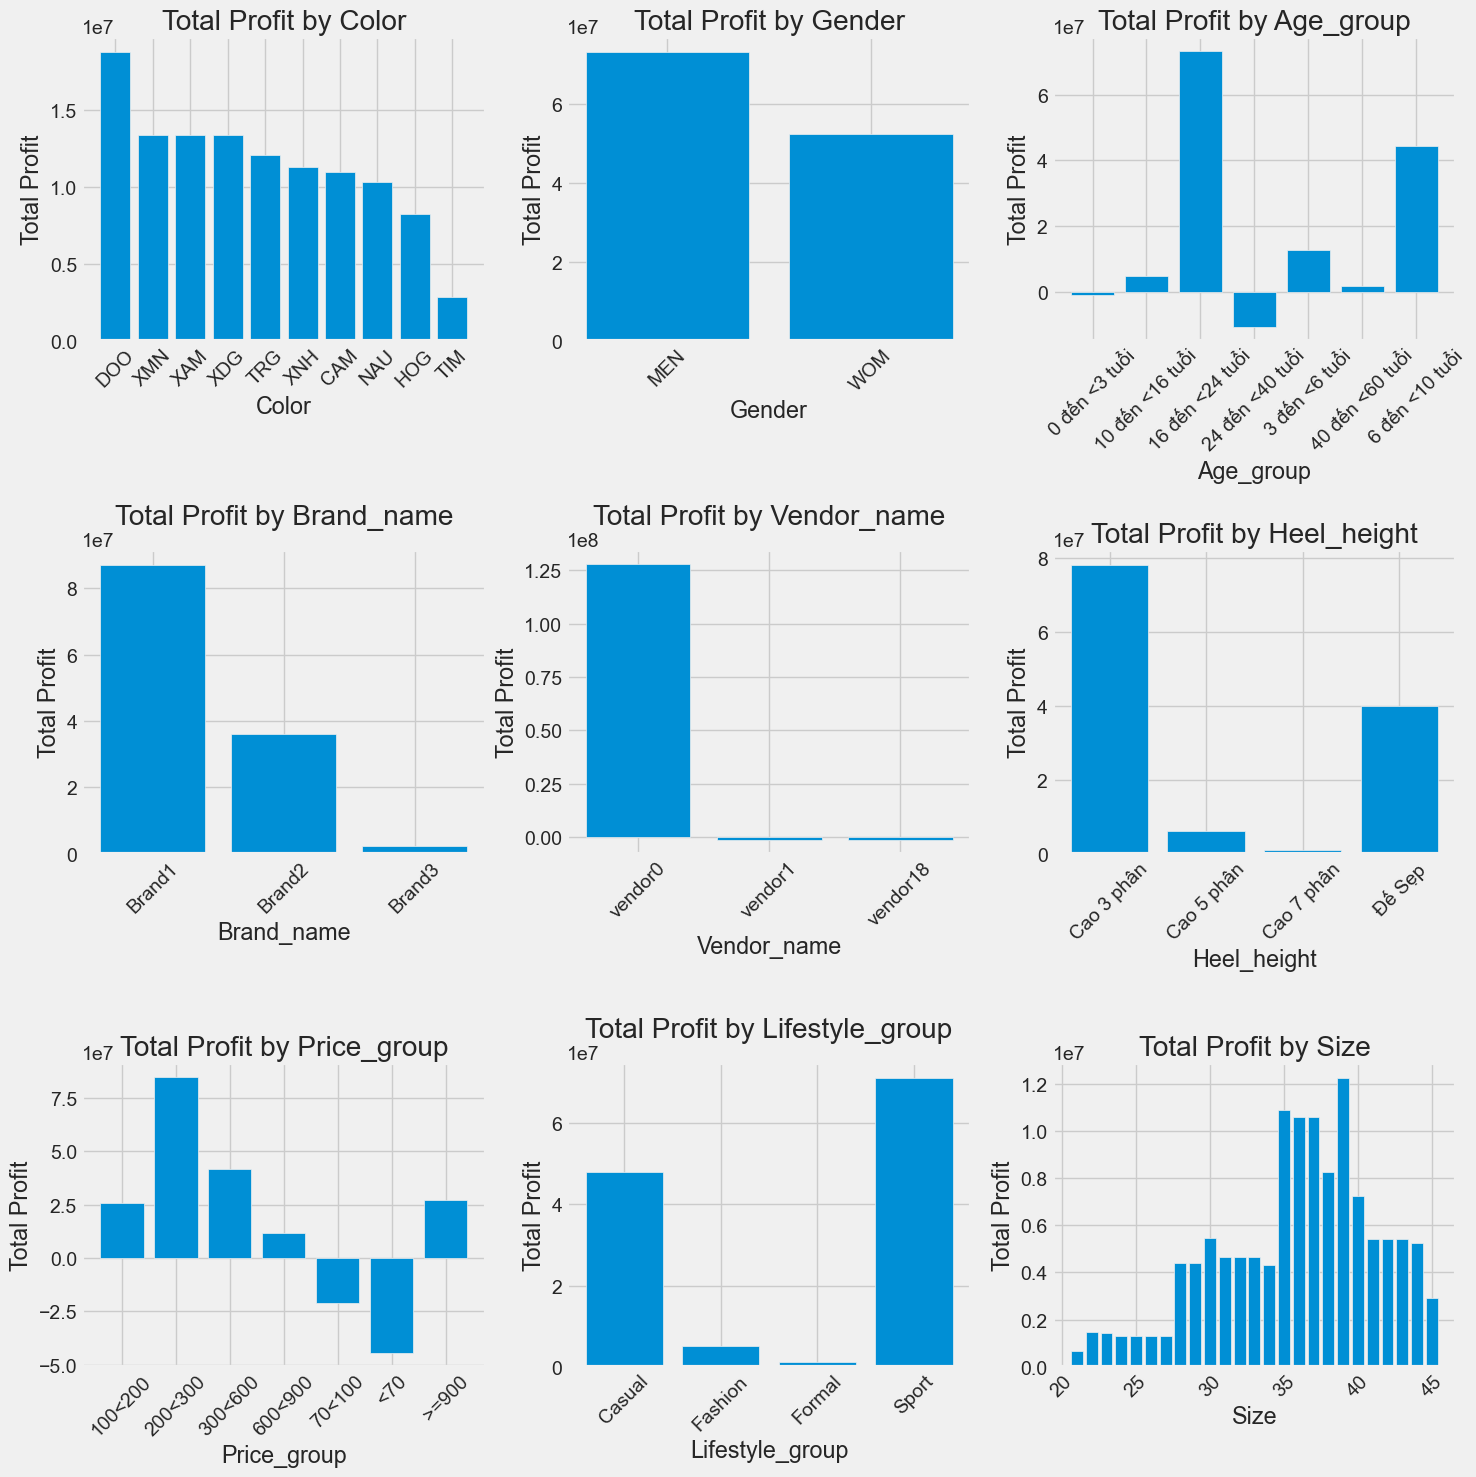

In [ ]:
categorical_variables = ['color', 'gender', 'age_group', 'brand_name', 'vendor_name', 'heel_height', 'price_group', 'lifestyle_group', 'size']

fig, axs = plt.subplots(3, 3, figsize=(15, 15))

# Plotting bar charts for each categorical variable
for i, variable in enumerate(categorical_variables):
    grouped_data = product_detail_df.groupby(variable)['profit'].sum().reset_index()

    # If the current variable is 'color', select only the top 5 colors with the highest profit
    if variable == 'color':
        grouped_data = grouped_data.sort_values('profit', ascending=False).head(10)

    ax = axs[i//3, i%3]
    ax.bar(grouped_data[variable], grouped_data['profit'])
    ax.set_xlabel(variable.capitalize())
    ax.set_ylabel('Total Profit')
    ax.set_title(f'Total Profit by {variable.capitalize()}')
    ax.tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

plt.tight_layout()
plt.show()

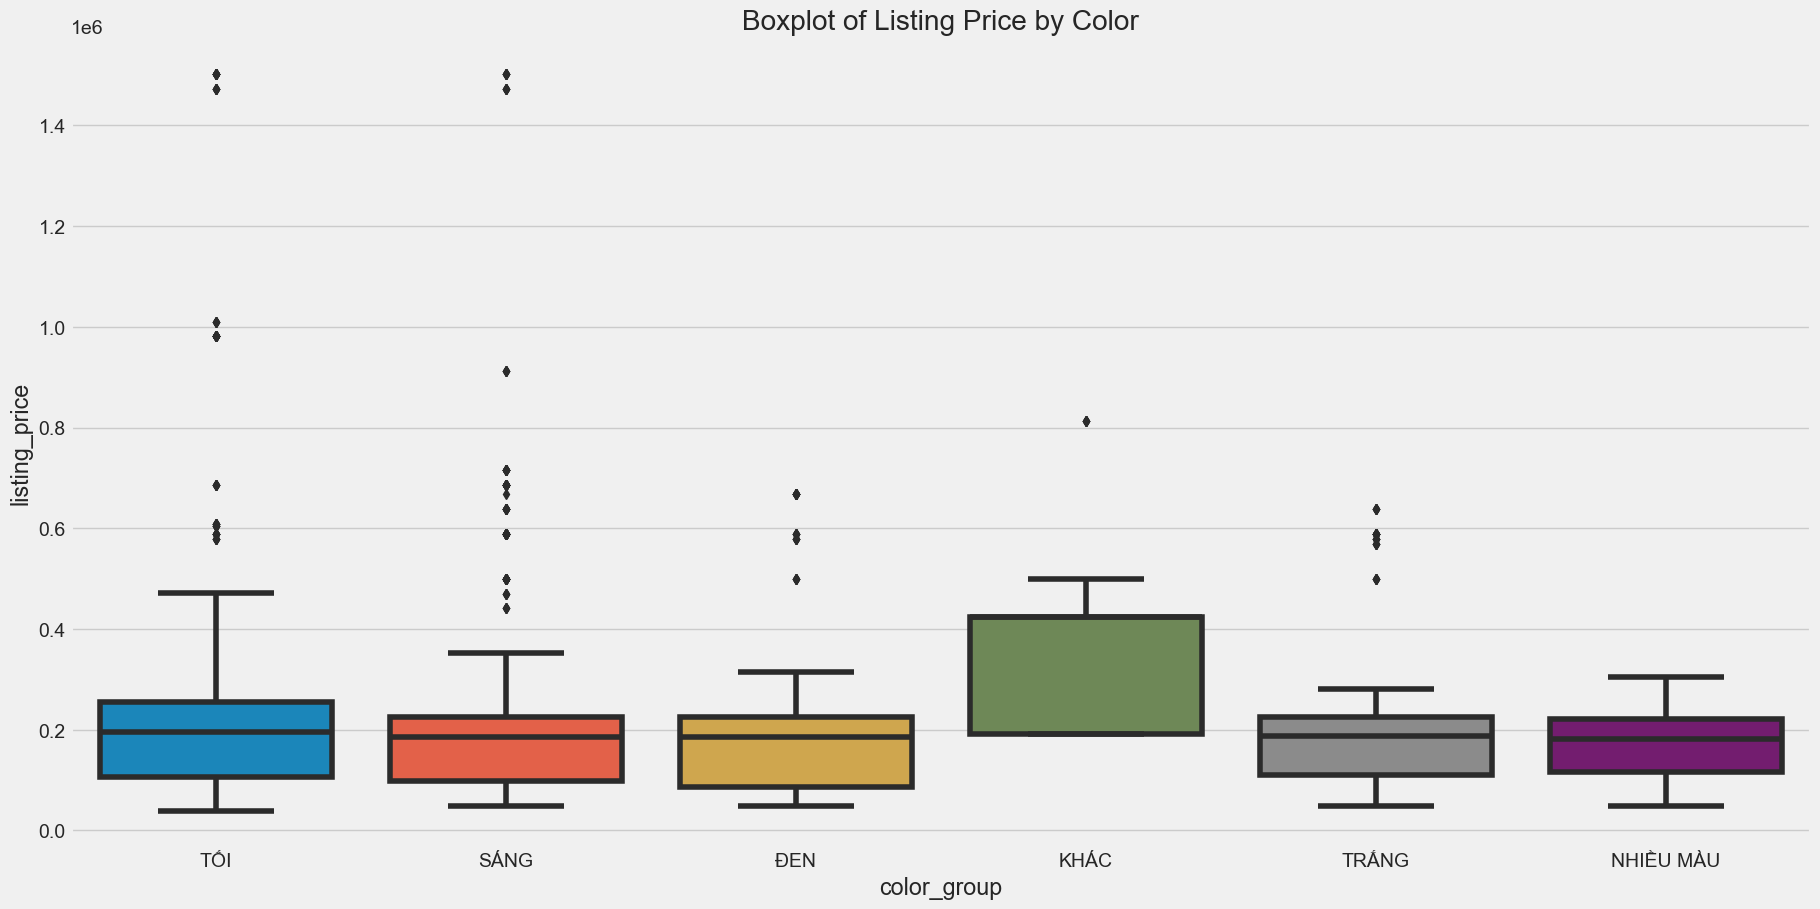

In [ ]:
plt.figure(figsize=(20, 10))
sns.boxplot(x='color_group', y='listing_price', data=product_detail_df)
plt.title('Boxplot of Listing Price by Color')
plt.show()

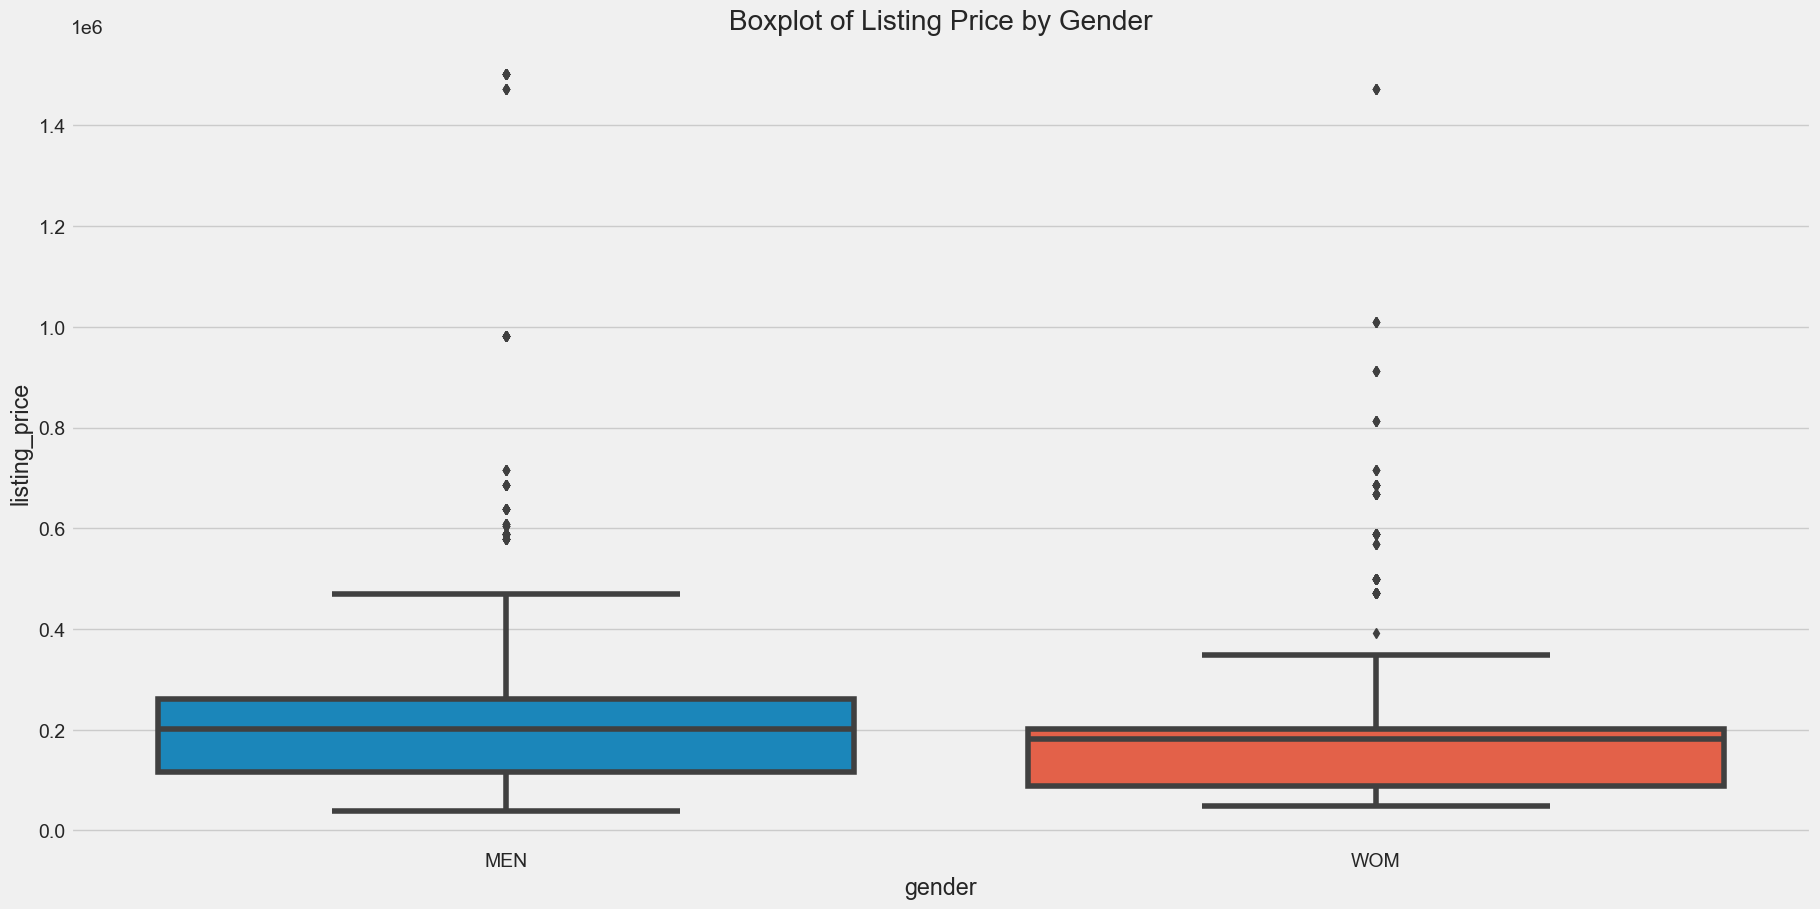

In [ ]:
plt.figure(figsize=(20, 10))
sns.boxplot(x='gender', y='listing_price', data=product_detail_df)
plt.title('Boxplot of Listing Price by Gender')
plt.show()

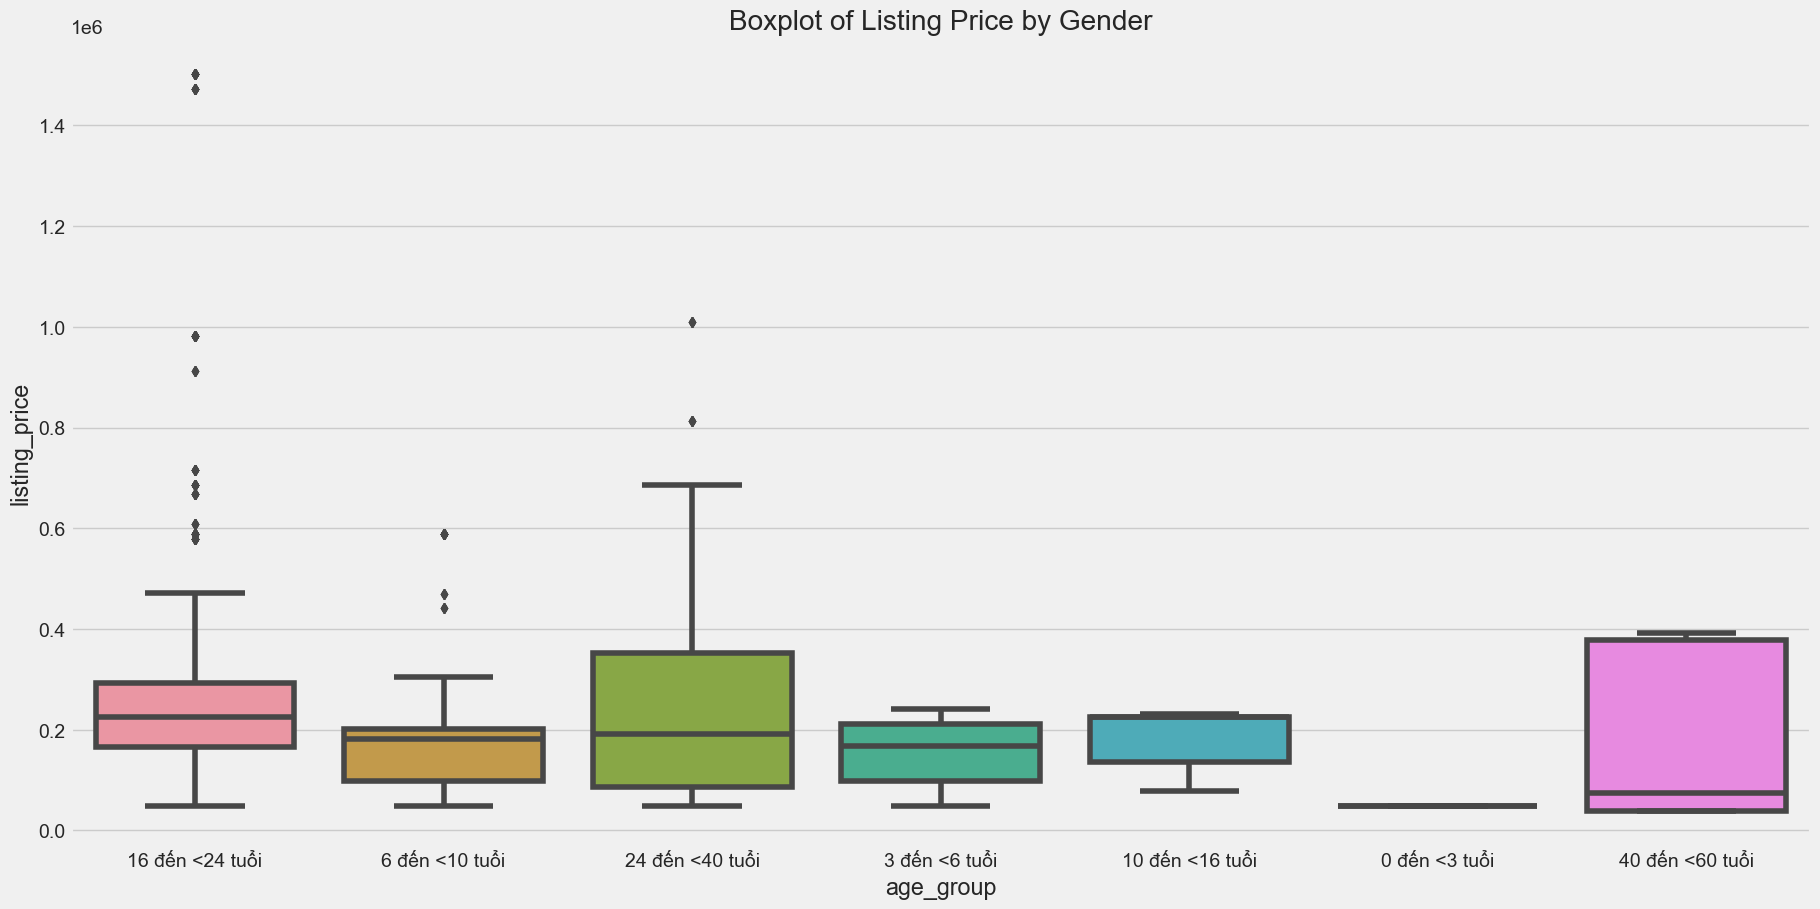

In [ ]:
plt.figure(figsize=(20, 10))
sns.boxplot(x='age_group', y='listing_price', data=product_detail_df)
plt.title('Boxplot of Listing Price by Gender')
plt.show()

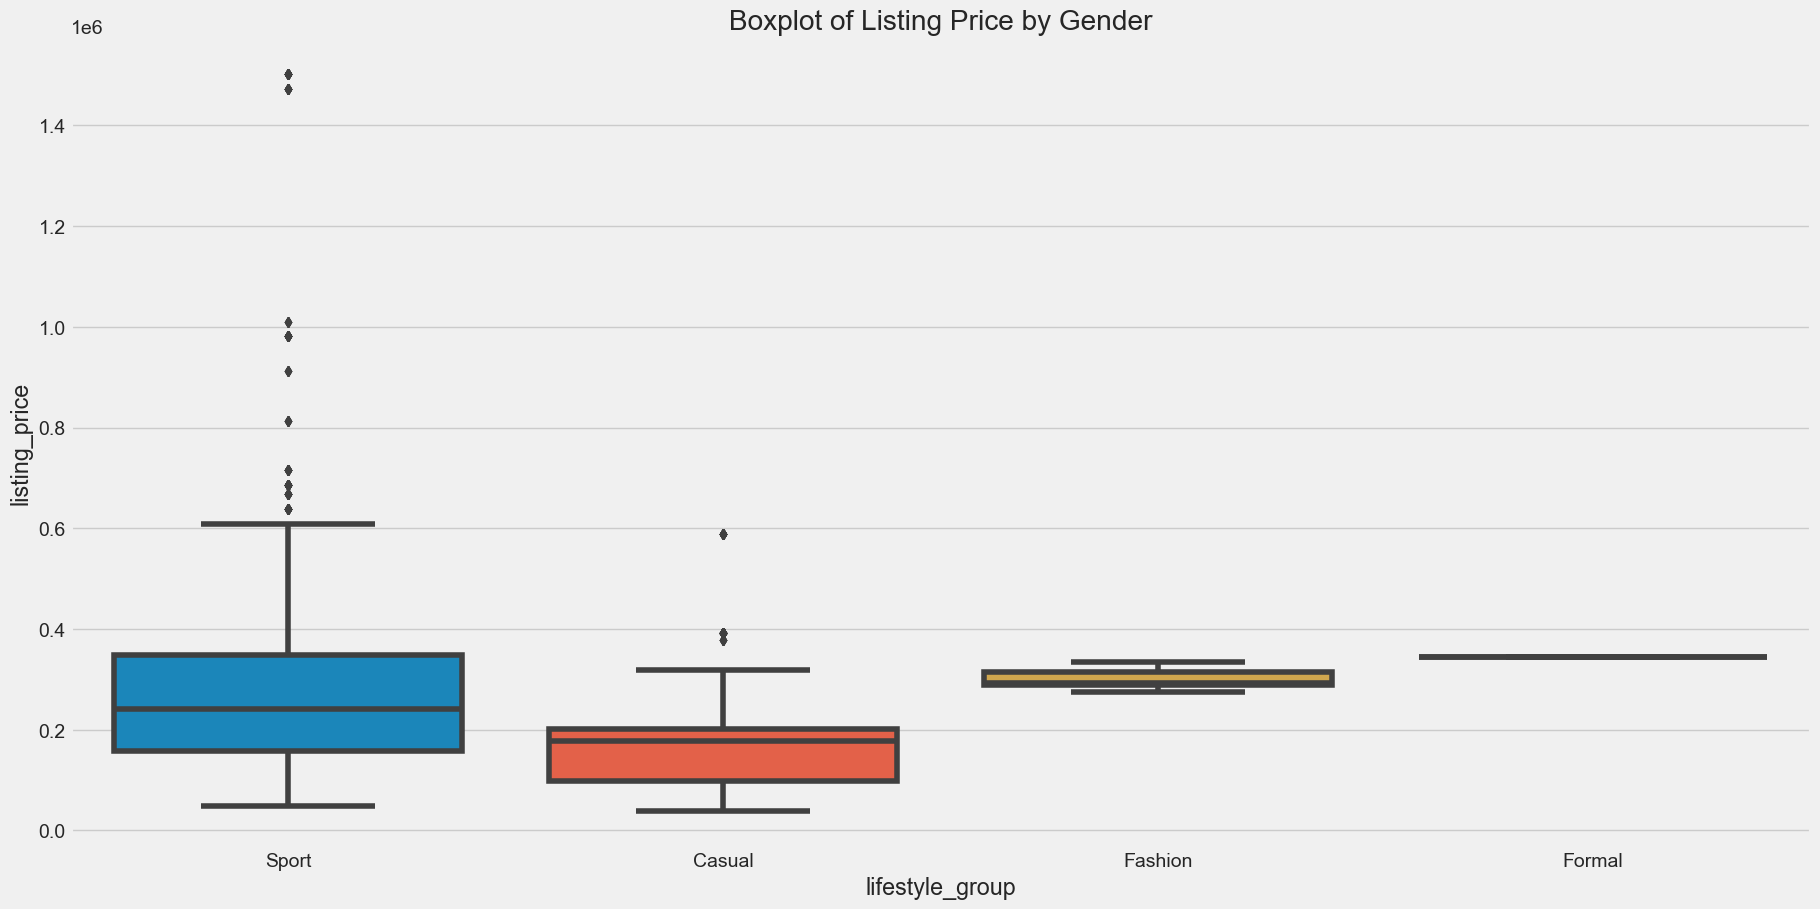

In [ ]:
plt.figure(figsize=(20, 10))
sns.boxplot(x='lifestyle_group', y='listing_price', data=product_detail_df)
plt.title('Boxplot of Listing Price by Gender')
plt.show()

In [ ]:


X = pd.get_dummies(product_detail_df[categorical_variables], drop_first=True)
y = product_detail_df['listing_price']

# Apply MinMaxScaler to X
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

# Apply MinMaxScaler to y
y = y.values.reshape(-1, 1)  # reshape to 2D array as required by the scaler
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Fit a Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

# Feature Importance
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})
print(feature_importance.sort_values(by='Importance', ascending=False))


Mean Squared Error: 0.0009388634283957049
                      Feature    Importance
53          price_group_>=900  3.665564e-01
49        price_group_300<600  2.054704e-01
50        price_group_600<900  1.233445e-01
41          brand_name_Brand2  1.009709e-01
48        price_group_200<300  9.003143e-02
52            price_group_<70  3.103022e-02
51         price_group_70<100  2.034689e-02
0                        size  1.722083e-02
6                   color_DOO  4.552219e-03
56      lifestyle_group_Sport  4.257835e-03
33                  color_XNH  3.622251e-03
34                 gender_WOM  2.812100e-03
25                  color_XAM  2.699876e-03
45     heel_height_Cao 5 phân  2.528076e-03
37  age_group_24 đến <40 tuổi  2.501258e-03
47         heel_height_Đế Sẹp  2.316916e-03
19                  color_TRG  2.208895e-03
42          brand_name_Brand3  2.173928e-03
40   age_group_6 đến <10 tuổi  1.927447e-03
21                  color_VAG  1.914716e-03
54    lifestyle_group_Fashion  1.5

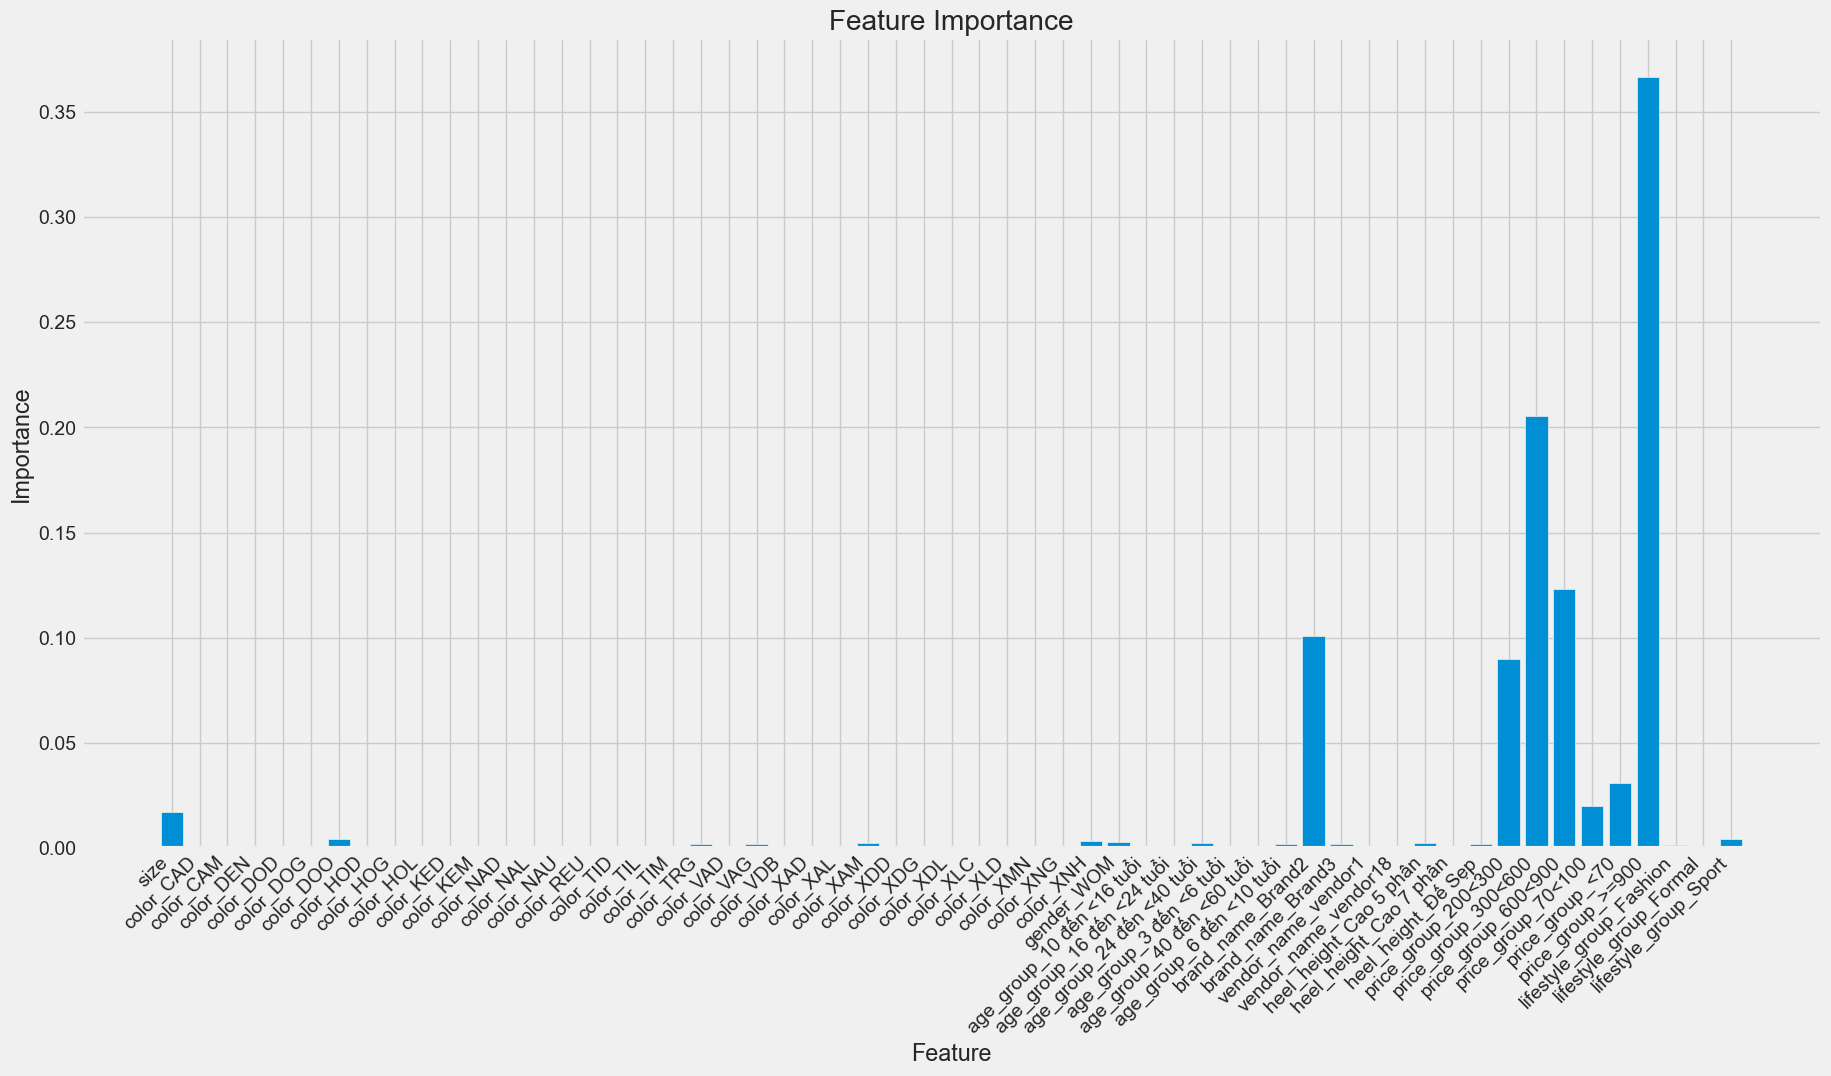

In [ ]:
plt.figure(figsize=(20, 10))
plt.bar(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
import re

X = pd.get_dummies(product_detail_df[categorical_variables], drop_first=True)
y = product_detail_df['listing_price']

# Convert feature names to string and remove invalid characters
X.columns = X.columns.astype(str)
X.columns = [re.sub(r'[\[\]<]', '', col) for col in X.columns]
print(X.columns)

# Apply MinMaxScaler to X
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

# Apply MinMaxScaler to y
y = y.values.reshape(-1, 1)  # reshape to 2D array as required by the scaler
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Fit an XGBoost Regressor
model = XGBRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

# Feature Importance
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})
print(feature_importance.sort_values(by='Importance', ascending=False))

Mean Squared Error: 0.001073307159530449
                     Feature  Importance
53         price_group_>=900    0.614946
50        price_group_600900    0.183151
49        price_group_300600    0.114588
48        price_group_200300    0.026368
52            price_group_70    0.015203
51         price_group_70100    0.010221
54   lifestyle_group_Fashion    0.004791
41         brand_name_Brand2    0.003331
18                 color_TIM    0.002671
40   age_group_6 đến 10 tuổi    0.002584
42         brand_name_Brand3    0.002491
31                 color_XMN    0.002184
19                 color_TRG    0.001610
56     lifestyle_group_Sport    0.001588
45    heel_height_Cao 5 phân    0.001346
14                 color_NAU    0.001307
37  age_group_24 đến 40 tuổi    0.001294
25                 color_XAM    0.001135
21                 color_VAG    0.001117
33                 color_XNH    0.001103
34                gender_WOM    0.000706
35  age_group_10 đến 16 tuổi    0.000636
27              

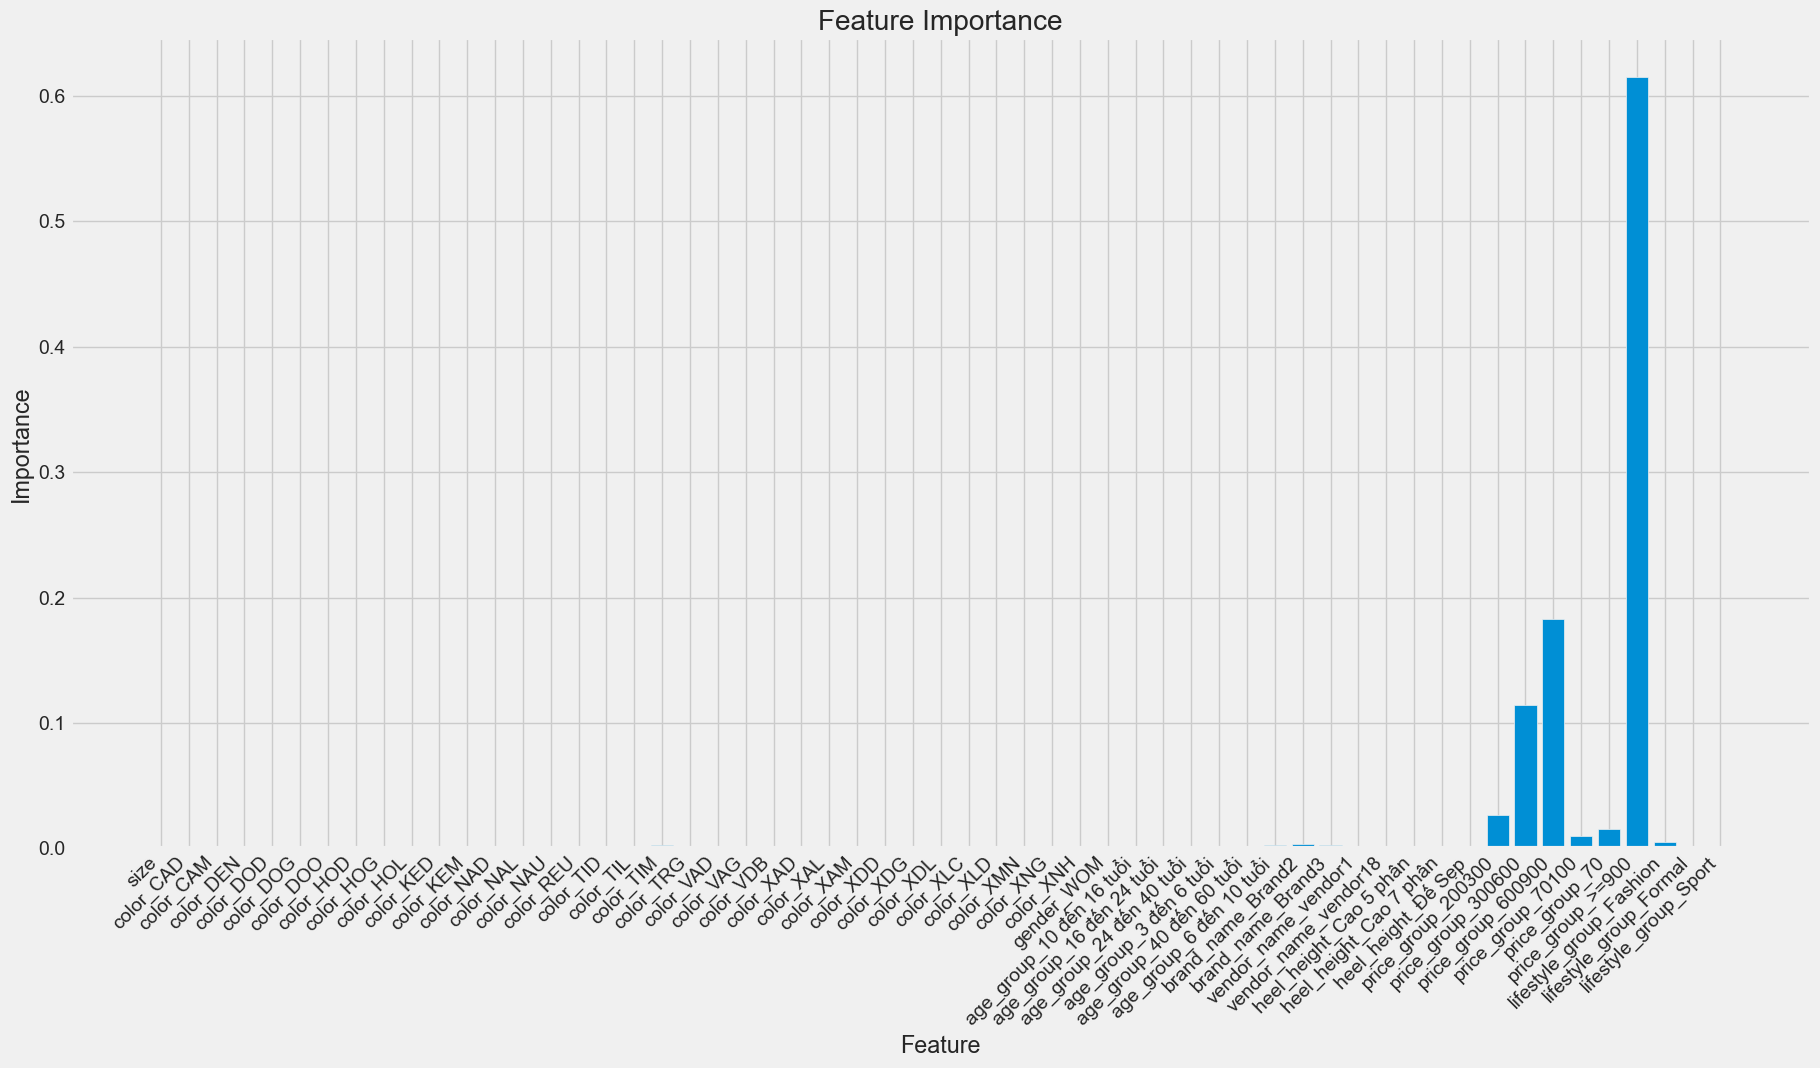

In [ ]:
plt.figure(figsize=(20, 10))
plt.bar(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=45, ha='right')
plt.show()